### Analisis de datos realizado por Nelson Martínez

El propósito de este documento es presentar el análisis de datos de los resultados de las simulaciones del trabajo final de máster:

"DESARROLLO DE UN MODELO BASADO EN AGENTES PARA LA SIMULACIÓN DE LA PROPAGACIÓN DE ENFERMEDADES INFECCIOSAS EN EVENTOS CONTROLADOS: EVALUACIÓN DE INTERVENCIONES EN SUPERMERCADOS DURANTE LA EPIDEMIA DEL COVID - 19"

En este Notebook se presentarán los resultados de los tipos de simulaciones realizadas en el proyecto, se mostrará de manera detallada el significado en cada uno de los resultados, en el informe del TFM se discutirá más a fondo como estos resultados se relacionan con la literatura del proyecto.

Las tipos de simulaciones se basan en 3 tipo:

1 - Simulaciones normales. En este tipo de simulación no existe ningún tipo de intervención no farmaceútica por parte de las autoridades y el supermercado sigue trabajando como si estuviera todo normal. Esta clase de escenario nos ayuda a visualizar como se comporta el contagio del virus en los momentos en que las autoridades no intervienen en lo absoluto.

2 - Simulaciones con uso de mascarilla. La primera intervención no farmaceútica que se utiliza es el uso de las mascarillas. Las cuales muchas organizaciones la han descrito como una de las maneras más simples y eficases para frenar el contagio por COVID. Para este caso solo un porcentaje de personas estarán llevando las mascarillas, y usar las mascarillas tendrá un rango de efectividad, esto debido a que según el tipo de tela que utilizad la persona, esto puede variar.

3 - Simulaciones basadas en logística. Para este último caso no solo se tiene el uso de mascarilla sino también que antes de que una persona entre a la simulación se le revisa la temperatura, si la persona es sintomática existe una probabilidad de que sea detectadad y no se deje entrar al local, luego de esto se pasa hacia la siguiente persona hasta que el local cumple con la cantidad de personas límite. También se limitaron la cantidad de filas para pagar que existe en la simulación.

La variable principal que se estará evaluando en este proyecto es el tiempo de exposición de las personas suceptibles a personas contagiadas, así que el objetivo principal de la implementación de las difentes intervenciones no farmaceúticas es reducir lo más posible este tiempo y que las personas aún puedan realizar la actividad teniendo la menor cantidad de problemas posibles.

### Configuración de la base de datos

In [2]:
'''
Ahora nos estaremos conectando a la base de datos local, aquí se guardan todos los datos realizados según el tipo de simulación
'''
import pandas as pd
from sqlalchemy import create_engine, text

DATABASE_NAME='data'
DATABASE_USERNAME='billinguser'
DATABASE_PASSWORD='Mglfya041100'
DATABASE_HOST='localhost'
DATABASE_PORT=5432

DATABASE_URL = f"postgresql://{DATABASE_USERNAME}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}"

# Prefer importing your existing config (DATABASE_URL / engine)
try:
    engine = create_engine(DATABASE_URL, pool_pre_ping=True)
    print("Using DATABASE_URL from database_configuration.py")
except Exception as e:
    print("The was an error in the database configuration")

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)

# Se crea una función para correr de manera retorica 
def run_sql(sql: str, params: dict | None = None):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn, params=params or {})


Using DATABASE_URL from database_configuration.py


### Análisis estadístico de general los datos.

In [3]:
# Cantidad de simulaciones por tipo de simulación
total_simulations = {}
# Observamos la cantidad de simulaciones actuales entre todos los tipos de simulaciones
total_simulations['Total de simulaciones'] = run_sql("""
    SELECT count(*)
    FROM simulations
""")

# Observamos la cantidad de simulaciones normales
total_simulations["Total de simulaciones normales"] = run_sql("""
    SELECT count(*)
    FROM simulations
    WHERE name LIKE 'test%'
""")

# Observamos la cantidad de simulaciones con mascarillas
total_simulations["Total de simulaciones con mascarillas"] = run_sql("""
    SELECT count(*)
    FROM simulations
    WHERE name LIKE 'mask%'
""")

# Observamos la cantidad de simulaciones con logistica
total_simulations["Total de simulaciones con logistica"] = run_sql("""
    SELECT count(*)
    FROM simulations
    WHERE name LIKE 'logic%'
""")

for key, value in total_simulations.items():
    print(f"{key}: {value['count'].iloc[0]}")


Total de simulaciones: 7472
Total de simulaciones normales: 2522
Total de simulaciones con mascarillas: 2520
Total de simulaciones con logistica: 2430


Podemos visualizar que tenemos la misma cantidad de simulaciones por cada tipo de simulación en el proyecto. 

In [4]:
# Cantidad de simulaciones por tipo de simulación
total_person_exposures = {}
# Observamos la cantidad de simulaciones actuales entre todos los tipos de simulaciones
total_person_exposures['Cantidad de personas expuestas'] = run_sql("""
    SELECT 
        COUNT(*)
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
""")

# Observamos la cantidad de simulaciones normales
total_person_exposures["Cantidad de personas expuestas en simulaciones normales"] = run_sql("""
    SELECT 
        COUNT(*)
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'test%'
""")

# Observamos la cantidad de simulaciones con mascarillas
total_person_exposures["Cantidad de personas expuestas en simulaciones con mascarillas"] = run_sql("""
    SELECT 
        COUNT(*)
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'mask%'
""")

# Observamos la cantidad de simulaciones con logistica
total_person_exposures["Cantidad de personas expuestas en simulaciones con logistica"] = run_sql("""
    SELECT 
        COUNT(*)
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'logic%'
""")

for key, value in total_person_exposures.items():
    print(f"""{key}: {value['count'].iloc[0]}, porcentaje que representa: {value['count'].iloc[0]/ total_person_exposures['Cantidad de personas expuestas']['count'].iloc[0]*100:.2f}%""")


Cantidad de personas expuestas: 84789, porcentaje que representa: 100.00%
Cantidad de personas expuestas en simulaciones normales: 40960, porcentaje que representa: 48.31%
Cantidad de personas expuestas en simulaciones con mascarillas: 32442, porcentaje que representa: 38.26%
Cantidad de personas expuestas en simulaciones con logistica: 11387, porcentaje que representa: 13.43%


In [5]:
# Diccionario para guardar la suma de tiempos de exposición
total_exposure_time = {}

# Suma total de tiempo de exposición en TODAS las simulaciones
total_exposure_time['Tiempo total de exposición (todas)'] = run_sql("""
    SELECT 
        SUM(pe.exposure_time_seconds) AS total_time
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
""")

# Simulaciones normales (test%)
total_exposure_time["Tiempo total de exposición en simulaciones normales"] = run_sql("""
    SELECT 
        SUM(pe.exposure_time_seconds) AS total_time
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'test%'
""")

# Simulaciones con mascarillas (mask%)
total_exposure_time["Tiempo total de exposición en simulaciones con mascarillas"] = run_sql("""
    SELECT 
        SUM(pe.exposure_time_seconds) AS total_time
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'mask%'
""")

# Simulaciones con logística (logic%)
total_exposure_time["Tiempo total de exposición en simulaciones con logística"] = run_sql("""
    SELECT 
        SUM(pe.exposure_time_seconds) AS total_time
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'logic%'
""")

# Extraer el total en segundos y convertir a horas
total_seconds = total_exposure_time['Tiempo total de exposición (todas)']["total_time"].iloc[0]
total_hours = total_seconds / 3600 if total_seconds is not None else 0

# Imprimir resultados con porcentaje
for key, value in total_exposure_time.items():
    # extraer el valor en segundos
    seconds = value["total_time"].iloc[0]
    hours = seconds / 3600 if seconds is not None else 0
    
    # calcular porcentaje sobre el total
    percentage = (hours / total_hours * 100) if total_hours > 0 else 0
    
    # imprimir con 2 decimales
    print(f"{key}: {hours:.2f} horas, porcentaje que representa: {percentage:.2f}%")



Tiempo total de exposición (todas): 316.48 horas, porcentaje que representa: 100.00%
Tiempo total de exposición en simulaciones normales: 228.35 horas, porcentaje que representa: 72.15%
Tiempo total de exposición en simulaciones con mascarillas: 72.64 horas, porcentaje que representa: 22.95%
Tiempo total de exposición en simulaciones con logística: 15.48 horas, porcentaje que representa: 4.89%


Se observa que, aunque el porcentaje de personas que estuvieron cerca de un individuo infectado es elevado, el tiempo de exposición resultó considerablemente menor gracias a la implementación generalizada del uso de mascarillas. Este valor se redujo aún más en los escenarios donde se aplicaron diferentes estrategias logísticas en el supermercado.

# Analísis de los datos

En esta sección se estará explicando más a fondo como se estructura la base de datos, la captura de cada uno de los datos en diferentes dataframes y generación basíca de gráficos que nos ayuden a visualizar el comportamiento de los tipos de simulaciones en el proyecto. 

In [3]:
# Captura de los datos en general
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people, infection_radius, infected_percentage
    FROM simulations
    ORDER BY timestamp DESC;
""")

# Person exposures (join name for convenience)
df_pe = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id;
""")

# Location exposures (join name for convenience)
df_le = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id;
""")

display(df_sims.head())
display(df_pe.head())
display(df_le.head())


,id,name,duration_seconds,timestamp,num_people,infection_radius,infected_percentage
0,7472,logic_simulation_p25_d5_ir0.05,1190.6,2025-09-03 19:31:23.504245,25,5.0,5
1,7471,logic_simulation_p25_d5_ir0.05,1116.8,2025-09-03 19:31:11.842328,25,5.0,5
2,7470,logic_simulation_p25_d5_ir0.05,1279.6,2025-09-03 19:31:00.213149,25,5.0,5
3,7469,logic_simulation_p25_d5_ir0.05,1173.6,2025-09-03 19:30:50.859003,25,5.0,5
4,7468,logic_simulation_p25_d5_ir0.05,1120.6,2025-09-03 19:30:40.563368,25,5.0,5


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,1,test_simulation_p10_d2_ir0.15,4,24.2
1,1,test_simulation_p10_d2_ir0.15,2,3.4
2,1,test_simulation_p10_d2_ir0.15,9,9.8
3,1,test_simulation_p10_d2_ir0.15,1,5.6
4,1,test_simulation_p10_d2_ir0.15,3,2.2


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,2,test_simulation_p10_d2_ir0.15,1060,420,4.8
1,5,test_simulation_p10_d2_ir0.15,560,190,1.8
2,6,test_simulation_p10_d2_ir0.15,270,450,1.2
3,6,test_simulation_p10_d2_ir0.15,560,310,3.0
4,6,test_simulation_p10_d2_ir0.15,810,280,1.8


In [4]:
# Captura de los datos normales
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims_normal = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people, infection_radius, infected_percentage
    FROM simulations
    WHERE name LIKE 'test%';
""")

# Person exposures (join name for convenience)
df_pe_normal = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'test%';
""")

# Location exposures (join name for convenience)
df_le_normal = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id
    WHERE s.name LIKE 'test%';
""")

display(df_sims_normal.head())
display(df_pe_normal.head())
display(df_le_normal.head())


,id,name,duration_seconds,timestamp,num_people,infection_radius,infected_percentage
0,361,test_simulation_p10_d2_ir0.15,1082.4,2025-09-02 03:55:52.192336,10,2.0,15
1,362,test_simulation_p10_d2_ir0.15,984.2,2025-09-02 03:55:55.605158,10,2.0,15
2,363,test_simulation_p10_d2_ir0.15,1123.8,2025-09-02 03:56:01.365557,10,2.0,15
3,364,test_simulation_p10_d2_ir0.15,963.0,2025-09-02 03:56:05.283595,10,2.0,15
4,365,test_simulation_p10_d2_ir0.15,999.2,2025-09-02 03:56:09.881267,10,2.0,15


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,1,test_simulation_p10_d2_ir0.15,4,24.2
1,1,test_simulation_p10_d2_ir0.15,2,3.4
2,1,test_simulation_p10_d2_ir0.15,9,9.8
3,1,test_simulation_p10_d2_ir0.15,1,5.6
4,1,test_simulation_p10_d2_ir0.15,3,2.2


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,2,test_simulation_p10_d2_ir0.15,1060,420,4.8
1,5,test_simulation_p10_d2_ir0.15,560,190,1.8
2,6,test_simulation_p10_d2_ir0.15,270,450,1.2
3,6,test_simulation_p10_d2_ir0.15,560,310,3.0
4,6,test_simulation_p10_d2_ir0.15,810,280,1.8


In [5]:
# Captura de los datos en simulaciones con mascarilla
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims_mask = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people, infection_radius, infected_percentage
    FROM simulations
    WHERE name LIKE 'mask%';
""")

# Person exposures (join name for convenience)
df_pe_mask = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'mask%';
""")

# Location exposures (join name for convenience)
df_le_mask = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id
    WHERE s.name LIKE 'mask%';
""")

display(df_sims_mask.head())
display(df_pe_mask.head())
display(df_le_mask.head())


,id,name,duration_seconds,timestamp,num_people,infection_radius,infected_percentage
0,2523,mask_simulation_p10_d2_ir0.15,1034.4,2025-09-02 17:43:17.813456,10,2.0,15
1,2524,mask_simulation_p10_d2_ir0.15,778.4,2025-09-02 17:43:21.621381,10,2.0,15
2,2525,mask_simulation_p10_d2_ir0.15,758.0,2025-09-02 17:43:25.144235,10,2.0,15
3,2526,mask_simulation_p10_d2_ir0.15,1147.6,2025-09-02 17:43:28.612695,10,2.0,15
4,2527,mask_simulation_p10_d2_ir0.15,912.6,2025-09-02 17:43:32.537937,10,2.0,15


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,2526,mask_simulation_p10_d2_ir0.15,8,13.2
1,2526,mask_simulation_p10_d2_ir0.15,9,6.0
2,2526,mask_simulation_p10_d2_ir0.15,10,4.6
3,2526,mask_simulation_p10_d2_ir0.15,6,0.8
4,2526,mask_simulation_p10_d2_ir0.15,5,1.6


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,2526,mask_simulation_p10_d2_ir0.15,1130,500,1.8
1,2527,mask_simulation_p10_d2_ir0.15,1380,380,1.4
2,2528,mask_simulation_p10_d2_ir0.15,880,200,1.2
3,2528,mask_simulation_p10_d2_ir0.15,1500,230,1.6
4,2528,mask_simulation_p10_d2_ir0.15,1510,230,1.2


In [6]:
# Captura de los datos en simulaciones con logistica
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims_logic = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people, infection_radius, infected_percentage
    FROM simulations
    WHERE name LIKE 'logic%';
""")

# Person exposures (join name for convenience)
df_pe_logic = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id
    WHERE s.name LIKE 'logic%';
""")

# Location exposures (join name for convenience)
df_le_logic = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id
    WHERE s.name LIKE 'logic%';
""")

display(df_sims_logic.head())
display(df_pe_logic.head())
display(df_le_logic.head())


,id,name,duration_seconds,timestamp,num_people,infection_radius,infected_percentage
0,4323,logic_simulation_p10_d2_ir0.15,1044.6,2025-09-03 04:11:08.433356,10,2.0,15
1,4324,logic_simulation_p10_d2_ir0.15,1051.6,2025-09-03 04:11:11.245301,10,2.0,15
2,4325,logic_simulation_p10_d2_ir0.15,853.4,2025-09-03 04:11:14.456728,10,2.0,15
3,4326,logic_simulation_p10_d2_ir0.15,1029.6,2025-09-03 04:11:17.509274,10,2.0,15
4,4327,logic_simulation_p10_d2_ir0.15,838.8,2025-09-03 04:11:20.437196,10,2.0,15


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,4327,logic_simulation_p10_d2_ir0.15,1,0.4
1,4327,logic_simulation_p10_d2_ir0.15,4,1.6
2,4329,logic_simulation_p10_d2_ir0.15,10,0.2
3,4329,logic_simulation_p10_d2_ir0.15,1,0.2
4,4330,logic_simulation_p10_d2_ir0.15,10,0.2


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,4339,logic_simulation_p10_d2_ir0.15,1370,380,2.0
1,4384,logic_simulation_p10_d2_ir0.15,560,320,2.4
2,4384,logic_simulation_p10_d2_ir0.15,1130,100,1.6
3,4396,logic_simulation_p10_d3_ir0.15,1510,360,2.8
4,4396,logic_simulation_p10_d3_ir0.15,1500,360,1.4


El proyeto tiene 3 tablas, las cuales capturan la información necesaria de cada uno de los tipos de simulaciones realizadas. Cada una de las tablas se explicarán a continuación:

1. Tabla de simulaciones. En esta tabla se registra de manera única cada simulación realizada, a partir de esta tabla se puede utilizar un ID único y adquirir información de las otras tablas a través de joins.
    - id: Esta columna es el ID único por simulación que existe en el proyecto.
    - name: Guarda el nombre según el tipo de simulación que se está registrando, las simulaciones que inician con test son las normales, con mask las de mascarilla y logic las que se implementan las últimas lógicas de intervenciones no farmaceúticas.
    - duration_seconds: Indica a cantidad de tiempo que ha durado la simulación en segundos.
    - timestamp: Indica el momento en el cual la simulación fue registrada.
    - num_people: Cantidad de personas en la simulación.
    - infection_radius: Área de infección de la persona contagiada, si es 2 metros significa que una persona contagiada podrá contagiar a alguien a un máximo de 1 metro. 
    - infected_percentage: Porcentaje de personas infectadas en la simulación

2. Tabla de registro de personas infectadas. En esta tabla se registran todas las personas infectadas por simulación. Se suman todos los tiempos en que la persona estuvo cerca de un infectado y se guarda en el registro.
    - simulation_id: ID único de la simulación.
    - simulation_name: Nombre del tipo de simulación.
    - person_id: ID único de la persona según el ID único de la simulación a la cual pertenece.
    - exposure_time_seconds: Suma total del tiempo expuesto de la persona suceptible en la simulación. 

3. Tabla de registro de las áreas de infección. En esta tabla se registran las áreas en las cuales las personas han sido infectadas y los tiempos de infección de dichas áreas.
    - simulation_id: ID único de la simulación.
    - simulation_name: Nombre del tipo de simulación.
    - x_coordinate: Coordinada X en donde una persona se infectó en la simulación. 
    - y_coordinate: Coordinada Y en donde una persona se infectó en la simulación. 
    - exposure_time_seconds: Suma total del tiempo de infección según el área en una simulación. 



### Pruebas estadísticas de los resultados
Las siguientes pruebas nos ayudará a verificar si los escenarios evaluados en el proyecto tienen diferencias estadísticamente significativas, esto ees clave para confirmar que la implementación de las diferentes intervenciones no farmaceúticas tuvieron resultados positivos en la reduccion del tiempo de exposición.



In [9]:
# To print out json formar

import json

def json_format(data):
    # Convertir a formato compatible con JSON
    data_json_ready = {k: [float(v[0]), float(v[1])] for k, v in data.items()}

    # Imprimir como JSON
    print(json.dumps(data_json_ready, indent=4))
    

In [7]:
import pandas as pd

# Agregar columna de grupo
df_pe_normal["group"] = "test"
df_pe_mask["group"] = "mask"
df_pe_logic["group"] = "logic"


# Concatenar todo
df_all = pd.concat([df_pe_normal, df_pe_mask, df_pe_logic], ignore_index=True)

# Solo nos interesa el tiempo de exposición
df_all = df_all[["group", "exposure_time_seconds"]]


In [11]:
import scipy.stats as st
import json
summary = (
    df_all.groupby("group")["exposure_time_seconds"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Intervalos de confianza 95%
confidence_intervals = {}
for g, vals in df_all.groupby("group")["exposure_time_seconds"]:
    ci = st.t.interval(
        0.95,
        len(vals)-1,
        loc=vals.mean(),
        scale=st.sem(vals)
    )
    confidence_intervals[g] = ci

print(summary)
json_format(confidence_intervals)

   group       mean        std  count
0  logic   4.895003   8.313555  11387
1   mask   8.060662  12.330151  32442
2   test  20.070107  23.833382  40960
{
    "logic": [
        4.742289941772491,
        5.047716205588534
    ],
    "mask": [
        7.926484860675483,
        8.194839348682756
    ],
    "test": [
        19.839291041094057,
        20.300923802655944
    ]
}


Se observa que los valores que describen la distribución de los tiempos de exposición en los distintos tipos de simulaciones, según el intervalo de confianza, indican que en el 95% de los casos se espera que la media del tiempo de exposición se ubique dentro de los rangos presentados anteriormente.

In [14]:
from scipy.stats import f_oneway

groups = [df_all[df_all["group"]==g]["exposure_time_seconds"] for g in df_all["group"].unique()]
anova_result = f_oneway(*groups)

print("ANOVA:", anova_result)


ANOVA: F_onewayResult(statistic=np.float64(5222.539695773856), pvalue=np.float64(0.0))


Un p valor cercano a 0 en la prueba de Annova indica que existen diferencias altamente significativas entre los grupos evaluados. 

In [ ]:
from scipy.stats import kruskal

kruskal_result = kruskal(*groups)
print("Kruskal-Wallis:", kruskal_result)


Kruskal-Wallis: KruskalResult(statistic=np.float64(16695.761923552174), pvalue=np.float64(0.0))


La prueba de Kruskal-Wallis nos indica que hay diferencias muy significativas, independientemente de supuestos de normalidad.

In [17]:
import scikit_posthocs as sp

posthoc = sp.posthoc_dunn(df_all, val_col="exposure_time_seconds", group_col="group", p_adjust="bonferroni")
print(posthoc)


               logic           mask  test
logic   1.000000e+00  3.070141e-174   0.0
mask   3.070141e-174   1.000000e+00   0.0
test    0.000000e+00   0.000000e+00   1.0


La matriz de p valores nos muestra que cada tipo de simulación tiene un p valor menor a 0.001, lo que nos indica que existen diferencias significativas, no producto del azar. 

#### Analisis de los resultados estadísticos

Estos análisis nos confiman que las diferencias en los tiempos de exposición de las diferentes simulaciones no son productos del azar, así mismo los intervalos de confianza no se superponen entre ellos, reforzando que las diferencias son reales y sustanciales. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import statannot

plt.figure(figsize=(8,6))
ax = sns.boxplot(x="group", y="exposure_time_seconds", data=df_all, palette="Set2")
sns.swarmplot(x="group", y="exposure_time_seconds", data=df_all, color="0.25")

# Añadir anotaciones de significancia (p-values)
pairs = [("logic", "test"), ("logic", "mask"), ("test", "mask")]
statannot.add_stat_annotation(ax, data=df_all, x="group", y="exposure_time_seconds",
                              box_pairs=pairs,
                              test="Kruskal",
                              text_format="star",
                              loc="outside",
                              verbose=2)

plt.title("Tiempo de exposición por grupo de simulación")
plt.ylabel("Tiempo de exposición (segundos)")
plt.show()


/tmp/ipykernel_7253/132191025.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="group", y="exposure_time_seconds", data=df_all, palette="Set2")


KeyboardInterrupt: 

### Distribución de los datos
#### Distribución de los tiempos de simulación

/tmp/ipykernel_6869/1278798136.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


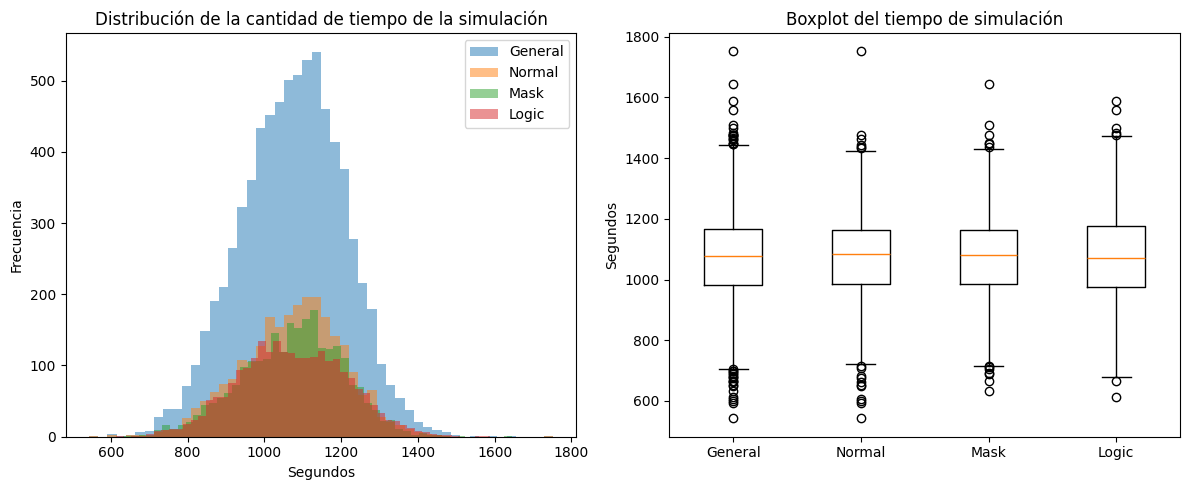

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Diccionario con los dataframes y sus etiquetas
datasets_sims = {
    "General": df_sims,
    "Normal": df_sims_normal,
    "Mask": df_sims_mask,
    "Logic": df_sims_logic
}

# Crear la figura con dos gráficos: histograma y boxplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Histograma (superpuesto) ---
for label, df in datasets_sims.items():
    axes[0].hist(
        df["duration_seconds"], 
        bins=50, alpha=0.5,  # transparencia
        label=label
    )

axes[0].set_title("Distribución de la cantidad de tiempo de la simulación")
axes[0].set_xlabel("Segundos")
axes[0].set_ylabel("Frecuencia")
axes[0].legend()

# --- Boxplot (comparativo) ---
axes[1].boxplot(
    [df["duration_seconds"] for df in datasets_sims.values()],
    labels=list(datasets_sims.keys()),
    vert=True
)
axes[1].set_title("Boxplot del tiempo de simulación")
axes[1].set_ylabel("Segundos")

plt.tight_layout()
plt.show()


In [12]:
# Datos descriptivos de los tiempos de simulación
summary_table = df_sims["duration_seconds"].describe()
print("Distribución de los tiempos en todos los datos")
display(summary_table)

# Datos descriptivos de los tiempos de simulación sin intervención
summary_table = df_sims_normal["duration_seconds"].describe()
print("Distribución de los tiempos en los datos normales")
display(summary_table)

# Datos descriptivos de los tiempos de simulación con mascarilla
summary_table = df_sims_mask["duration_seconds"].describe()
print("Distribución de los tiempos en los datos con mascarilla")
display(summary_table)

# Datos descriptivos de los tiempos de simulación con intervención logisitica
summary_table = df_sims_logic["duration_seconds"].describe()
print("Distribución de los tiempos en los datos con logistica")
display(summary_table)

Distribución de los tiempos en todos los datos


count    7472.000000
mean     1073.452222
std       134.946776
min       542.600000
25%       982.600000
50%      1078.800000
75%      1167.600000
max      1752.400000
Name: duration_seconds, dtype: float64

Distribución de los tiempos en los datos normales


count    2522.000000
mean     1073.190563
std       132.251814
min       542.600000
25%       986.050000
50%      1083.100000
75%      1164.400000
max      1752.400000
Name: duration_seconds, dtype: float64

Distribución de los tiempos en los datos con mascarilla


count    2520.000000
mean     1073.161984
std       131.933516
min       632.600000
25%       984.350000
50%      1081.800000
75%      1164.050000
max      1645.600000
Name: duration_seconds, dtype: float64

Distribución de los tiempos en los datos con logistica


count    2430.000000
mean     1074.024774
std       140.735498
min       614.000000
25%       975.850000
50%      1070.800000
75%      1175.400000
max      1586.800000
Name: duration_seconds, dtype: float64

La distribución del tiempo de simulación nos muestra como cada una de las simulaciones tienen tiempo bien parecidos, siendo la simulación de lógica la única que tiene una distribución un poco diferente, esto debido a que se cambia los comportamientos de los agentes a diferencia de los otros dos tipos de simulaciones.

#### Distribución de los tiempos según la cantidad de personas

En la siguiente figura se puede observar cuales son las distribuciones de los tiempos que duran las simulaciones segń la cantidad de personas, se puede observar como cada vez que el grupo de personas es más grande el tiempo de simulación es más grande. También es importante saber que la única variable que interviene en la cantidad de tiempo que dura una simulación, es la lógica que existe en el movimiento de las personas en esa simulación y la cantidad de persoans que existe en la simulación. 

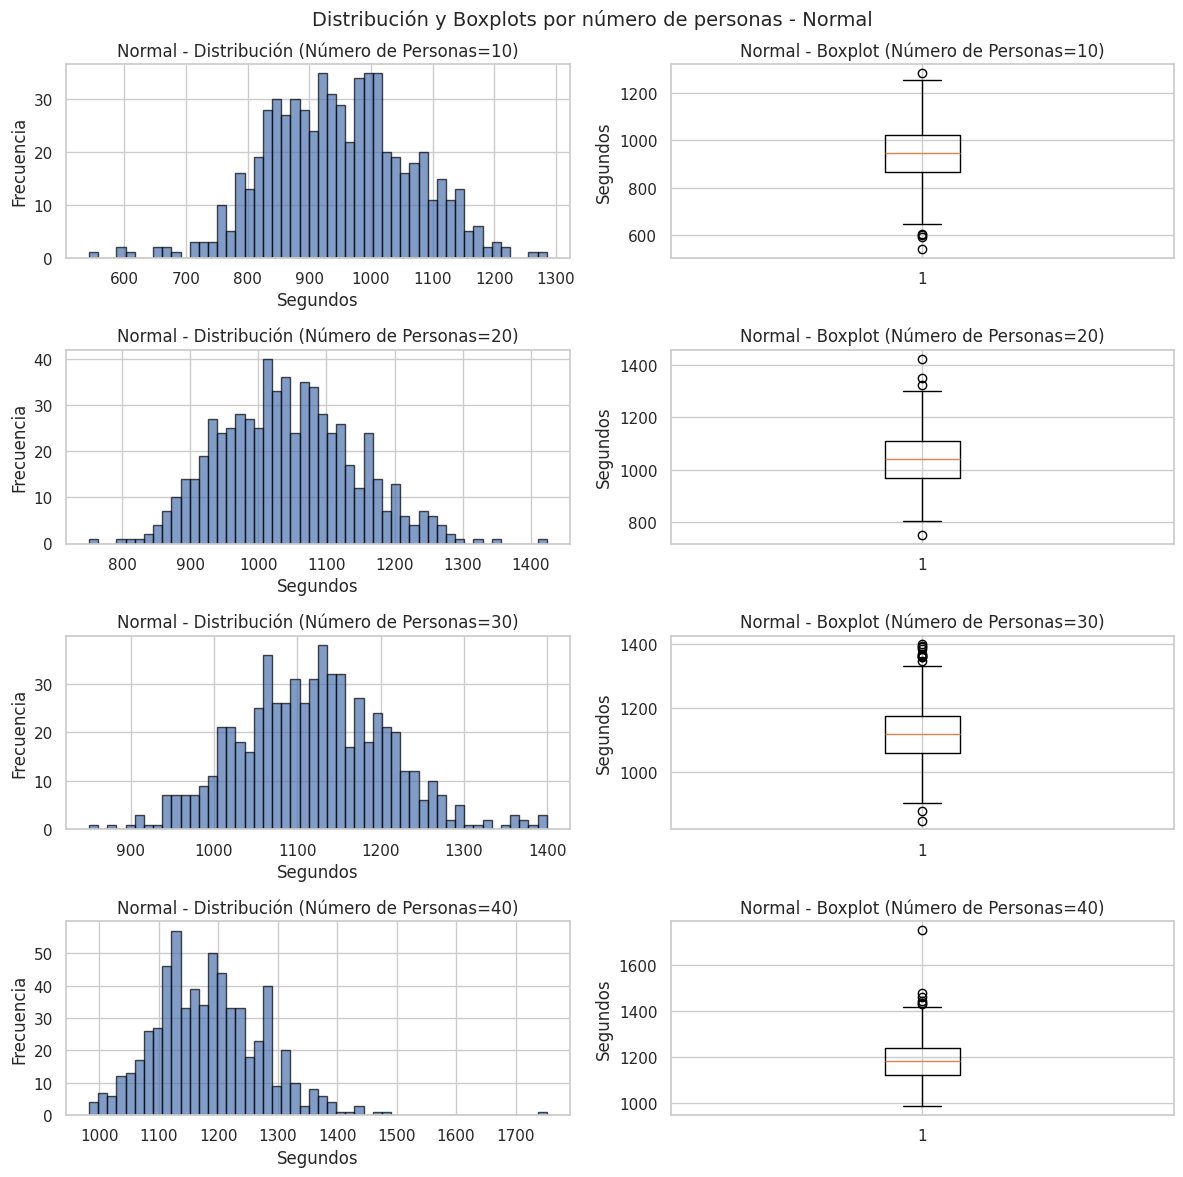

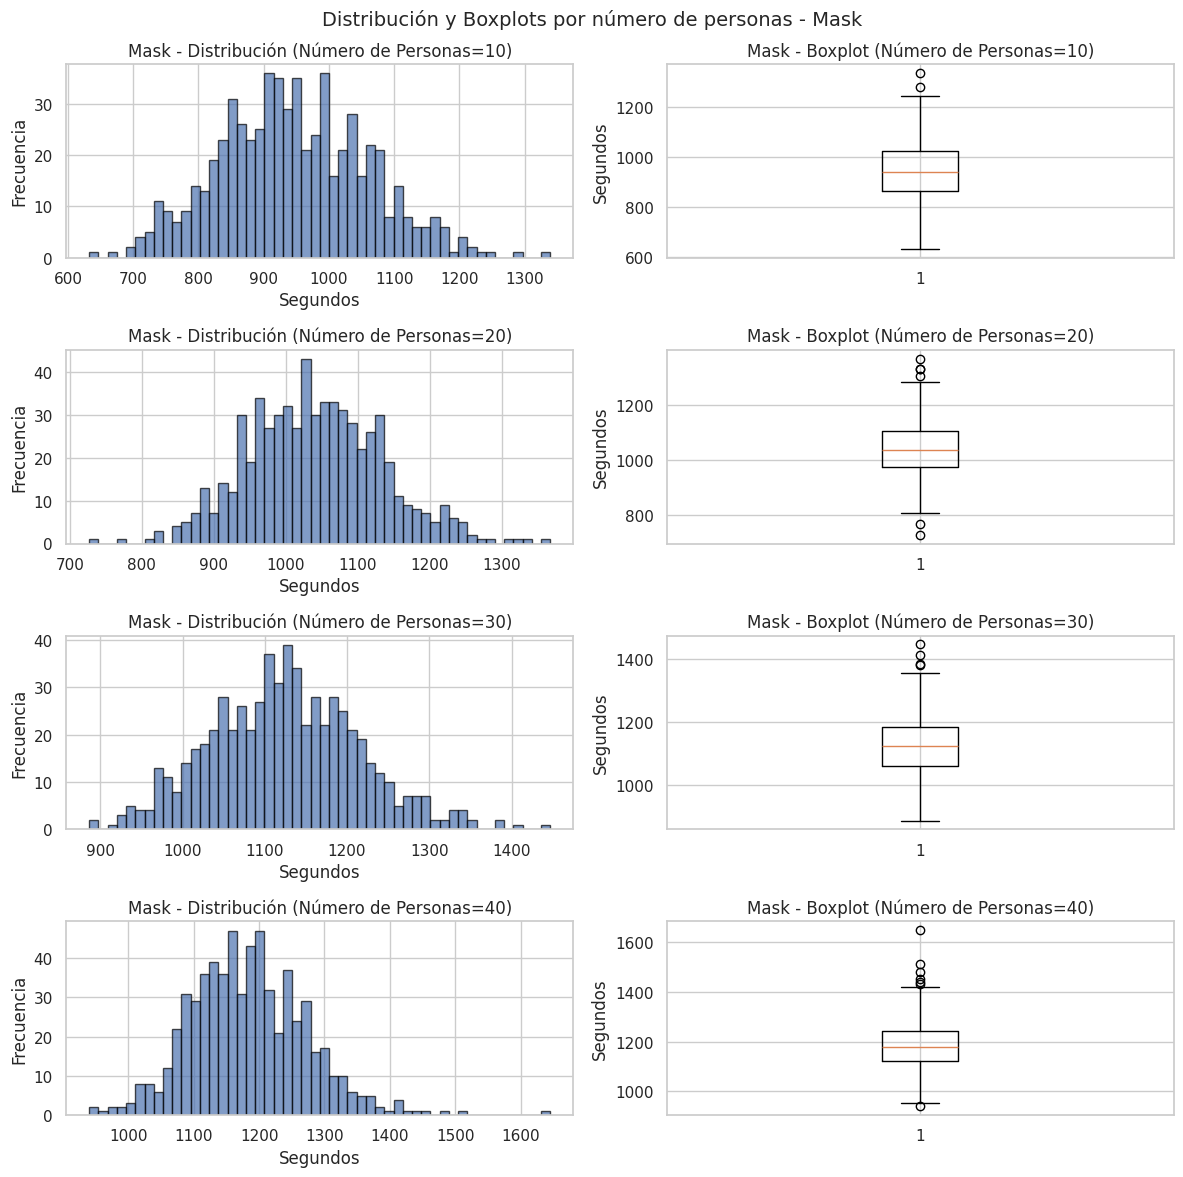

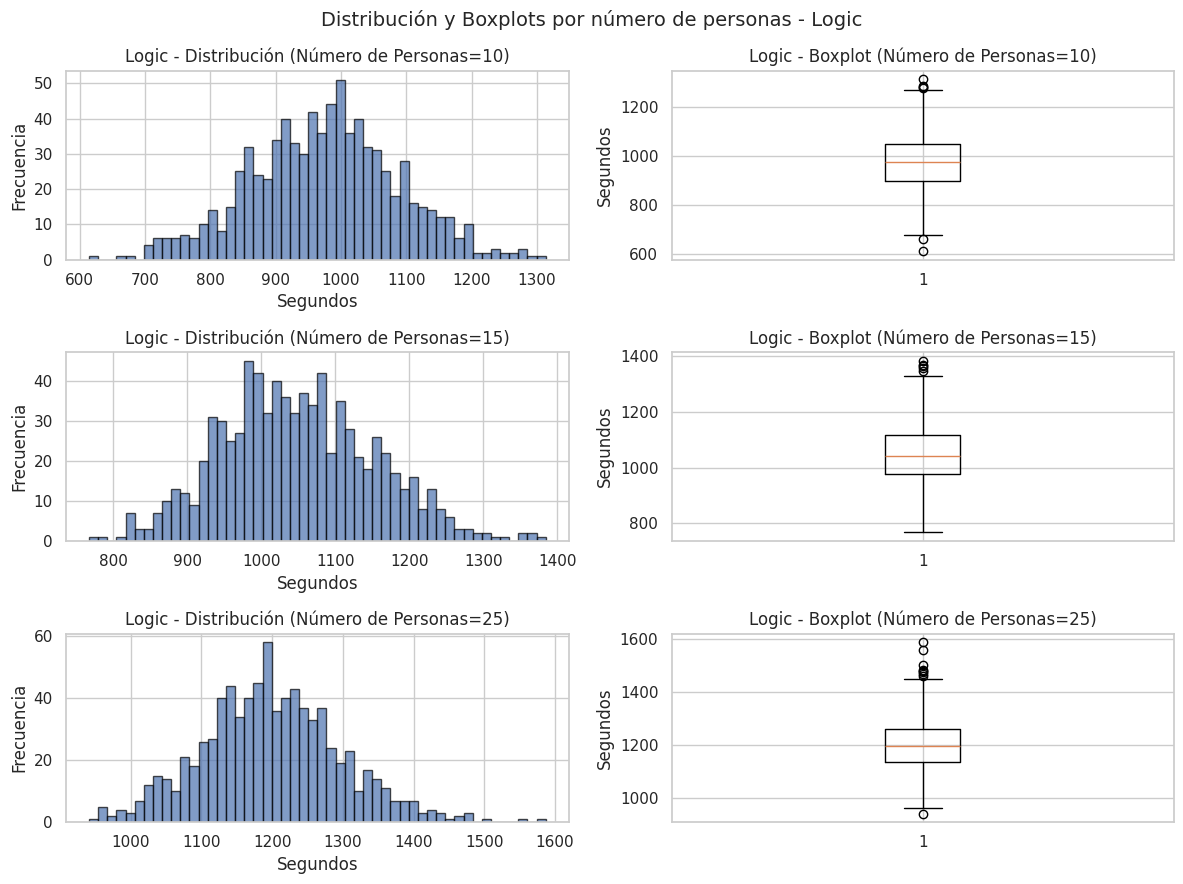

In [37]:
import matplotlib.pyplot as plt

# Diccionario con todos los tipos de simulaciones
datasets_sims = {
    "Normal": df_sims_normal,
    "Mask": df_sims_mask,
    "Logic": df_sims_logic
}

for label, df in datasets_sims.items():
    unique_groups = sorted(df["num_people"].unique())
    fig, axes = plt.subplots(len(unique_groups), 2, figsize=(12, 3*len(unique_groups)))

    for i, group in enumerate(unique_groups):
        data = df[df["num_people"] == group]["duration_seconds"]

        # Histograma
        axes[i][0].hist(data, bins=50, edgecolor="black", alpha=0.7)
        axes[i][0].set_title(f"{label} - Distribución (Número de Personas={group})")
        axes[i][0].set_xlabel("Segundos")
        axes[i][0].set_ylabel("Frecuencia")

        # Boxplot
        axes[i][1].boxplot(data, vert=True)
        axes[i][1].set_title(f"{label} - Boxplot (Número de Personas={group})")
        axes[i][1].set_ylabel("Segundos")

    plt.suptitle(f"Distribución y Boxplots por número de personas - {label}", fontsize=14)
    plt.tight_layout()
    plt.show()


A continuación se puede observar de manera numérica lo representado anteriormente.

In [14]:
# Diccionario con los datasets
datasets_sims = {
    "Normal": df_sims_normal,
    "Mask": df_sims_mask,
    "Logic": df_sims_logic
}

summary_results = {}

for label, df in datasets_sims.items():
    summary_results[label] = df.groupby("num_people")["duration_seconds"].describe()

# Mostrar cada resumen
for label, summary in summary_results.items():
    print(f"\n--- {label} ---")
    display(summary)



--- Normal ---


,count,mean,std,min,25%,50%,75%,max
num_people,,,,,,,,
10,632.0,947.517722,113.803253,542.6,866.45,944.8,1023.10,1285.2
20,630.0,1042.763175,99.010362,751.6,968.50,1038.8,1108.15,1423.0
30,630.0,1118.185079,88.818092,850.0,1059.40,1119.4,1174.95,1399.4
40,630.0,1184.695238,90.222307,982.8,1121.10,1180.4,1239.90,1752.4



--- Mask ---


,count,mean,std,min,25%,50%,75%,max
num_people,,,,,,,,
10,630.0,945.538095,113.283125,632.6,863.50,940.3,1026.40,1339.4
20,630.0,1040.129206,93.229308,726.8,973.30,1035.9,1103.70,1367.2
30,630.0,1123.597778,90.495987,886.4,1061.05,1122.9,1184.80,1447.2
40,630.0,1183.382857,88.724950,940.0,1122.65,1180.0,1241.35,1645.6



--- Logic ---


,count,mean,std,min,25%,50%,75%,max
num_people,,,,,,,,
10,810.0,974.486914,113.367286,614.0,899.55,978.0,1048.65,1313.6
15,810.0,1048.641235,103.617825,767.0,977.80,1043.3,1118.80,1384.4
25,810.0,1198.946173,98.436847,941.2,1134.60,1194.4,1260.35,1586.8


#### Distribución de los tiempos de infección por persona según el tipo de simulación. 

Los siguientes gráficos buscan mostrar como cambian los tiempos de infección según los tipos de técnicas implementadas, también se quiere mostrar cual se las variables que fueron tomadas por tipo de simulación tiene mayor efecto en el tiempo de exposición.



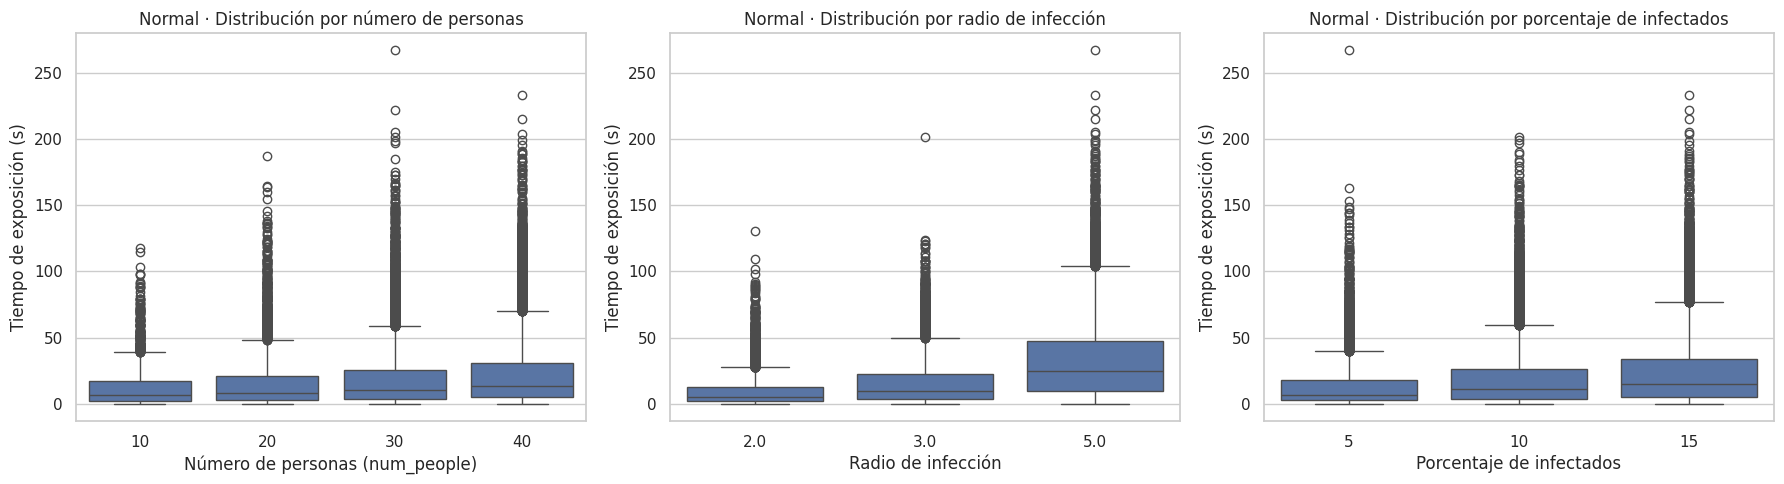

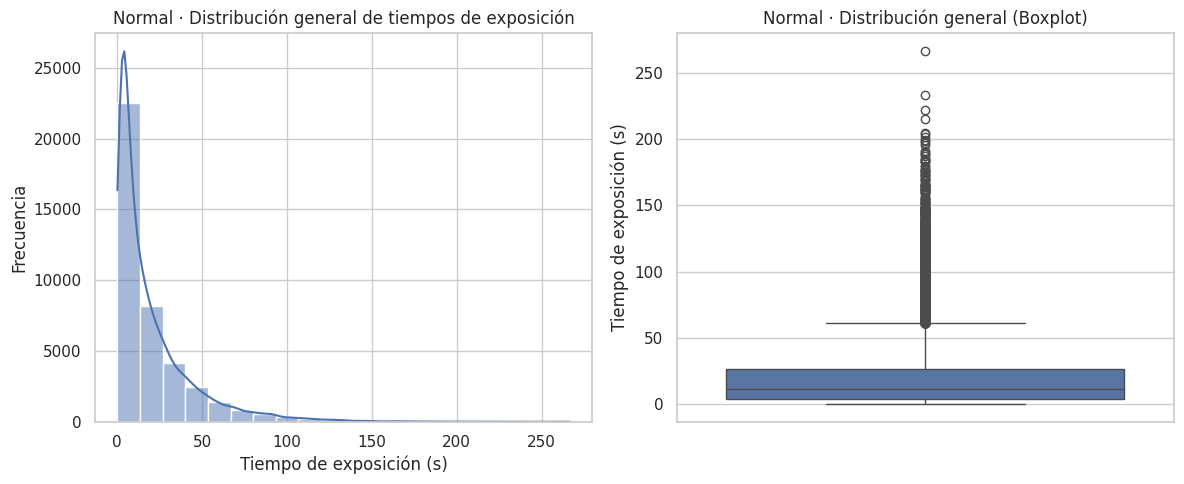


=== Normal · Estadísticas descriptivas (exposure_time_seconds) ===
Media:   20.07
Mediana: 11.20
Std:     23.83
Mín:     0.20
Máx:     266.60


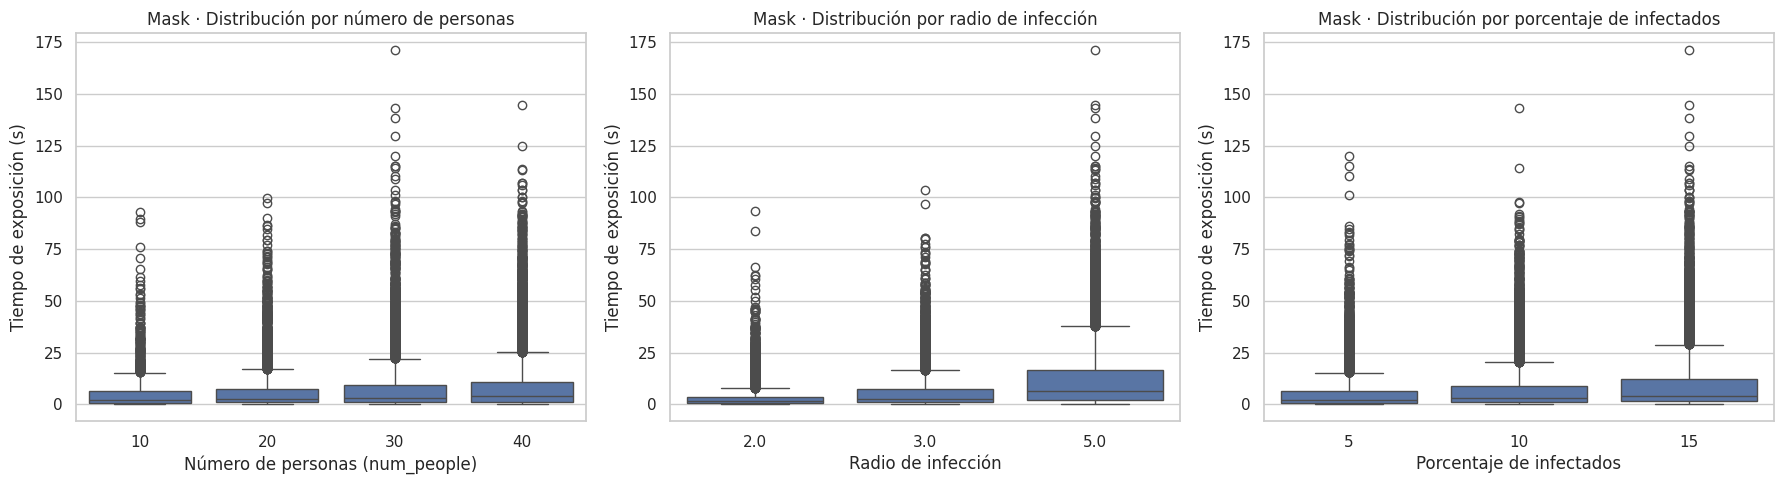

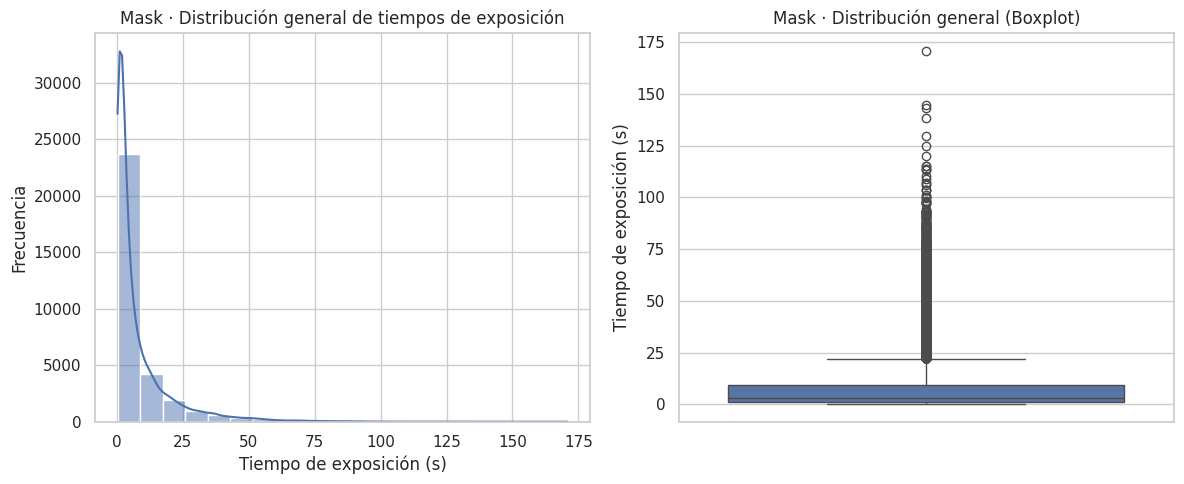


=== Mask · Estadísticas descriptivas (exposure_time_seconds) ===
Media:   8.06
Mediana: 3.20
Std:     12.33
Mín:     0.20
Máx:     171.00


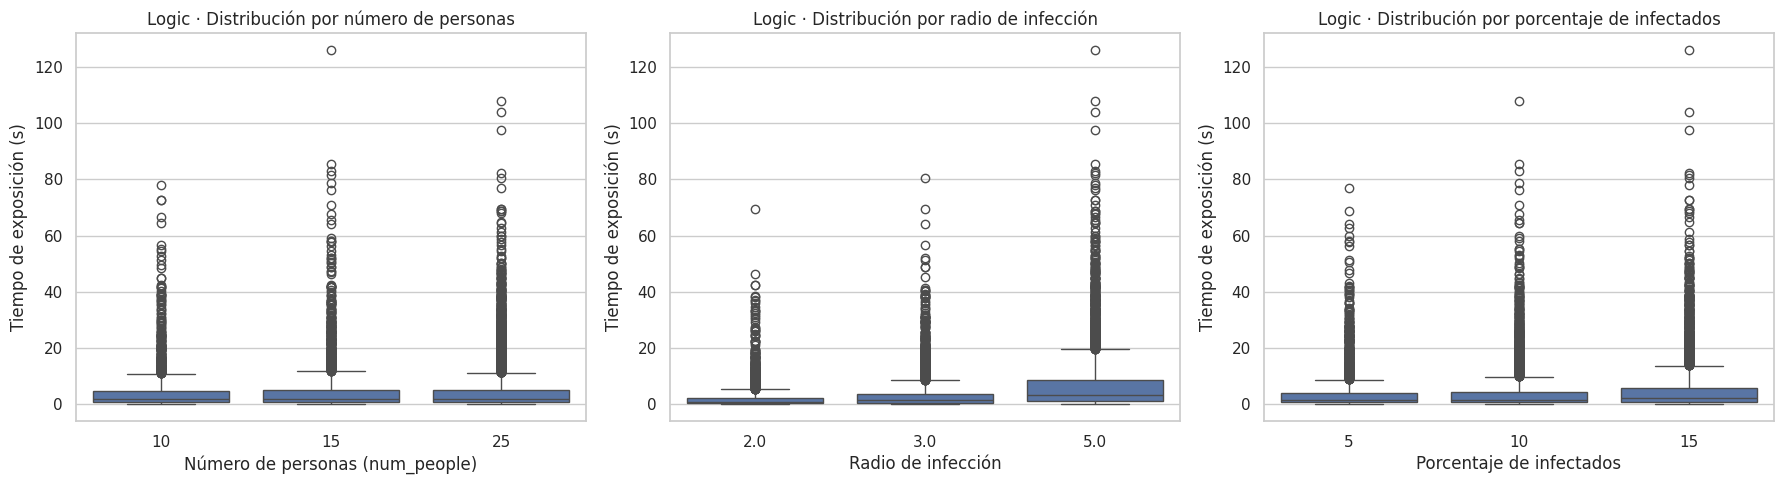

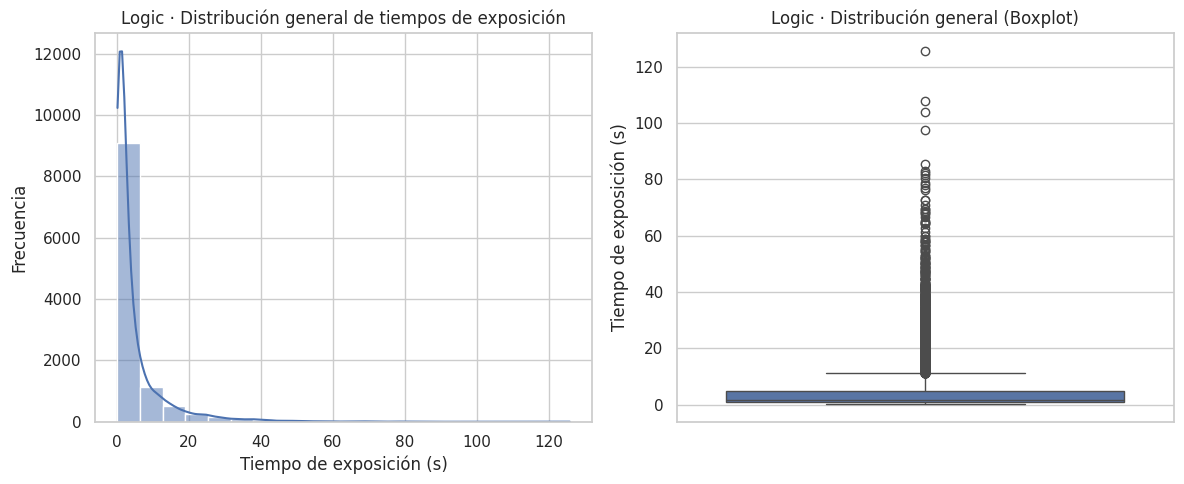


=== Logic · Estadísticas descriptivas (exposure_time_seconds) ===
Media:   4.90
Mediana: 1.80
Std:     8.31
Mín:     0.20
Máx:     125.80


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Pares de dataframes por tipo ----
datasets = {
    "Normal":  {"sims": df_sims_normal, "pe": df_pe_normal},
    "Mask":    {"sims": df_sims_mask, "pe": df_pe_mask},
    "Logic":   {"sims": df_sims_logic, "pe": df_pe_logic},
}

sns.set(style="whitegrid")

def build_combined(df_sims, df_pe):
    # unir tiempos de exposición con parámetros de simulación
    df_combined = df_pe.merge(
        df_sims, left_on="simulation_id", right_on="id", how="left"
    )
    # asegurar que exposure_time_seconds sea numérico
    df_combined["exposure_time_seconds"] = pd.to_numeric(
        df_combined["exposure_time_seconds"], errors="coerce"
    )
    return df_combined

for label, pair in datasets.items():
    dfc = build_combined(pair["sims"], pair["pe"])

    # -------- Figura 1: Boxplots por num_people, infection_radius e infected_percentage --------
    plt.figure(figsize=(18, 5))  # más ancha para 3 subgráficos

    plt.subplot(1, 3, 1)
    sns.boxplot(data=dfc, x="num_people", y="exposure_time_seconds")
    plt.title(f'{label} · Distribución por número de personas')
    plt.xlabel("Número de personas (num_people)")
    plt.ylabel("Tiempo de exposición (s)")

    plt.subplot(1, 3, 2)
    sns.boxplot(data=dfc, x="infection_radius", y="exposure_time_seconds")
    plt.title(f"{label} · Distribución por radio de infección")
    plt.xlabel("Radio de infección")
    plt.ylabel("Tiempo de exposición (s)")

    plt.subplot(1, 3, 3)
    sns.boxplot(data=dfc, x="infected_percentage", y="exposure_time_seconds")
    plt.title(f"{label} · Distribución por porcentaje de infectados")
    plt.xlabel("Porcentaje de infectados")
    plt.ylabel("Tiempo de exposición (s)")

    plt.tight_layout()
    plt.show()

    # -------- Figura 2: Distribución general (hist + KDE) y Boxplot --------
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(dfc["exposure_time_seconds"], kde=True, bins=20)
    plt.title(f"{label} · Distribución general de tiempos de exposición")
    plt.xlabel("Tiempo de exposición (s)")
    plt.ylabel("Frecuencia")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=dfc["exposure_time_seconds"])
    plt.title(f"{label} · Distribución general (Boxplot)")
    plt.ylabel("Tiempo de exposición (s)")

    plt.tight_layout()
    plt.show()

    # -------- Stats descriptivas --------
    print(f"\n=== {label} · Estadísticas descriptivas (exposure_time_seconds) ===")
    print(f"Media:   {dfc['exposure_time_seconds'].mean():.2f}")
    print(f"Mediana: {dfc['exposure_time_seconds'].median():.2f}")
    print(f"Std:     {dfc['exposure_time_seconds'].std():.2f}")
    print(f"Mín:     {dfc['exposure_time_seconds'].min():.2f}")
    print(f"Máx:     {dfc['exposure_time_seconds'].max():.2f}")


En los resultados podemos observar como la variable de radio de infección es la que tiene más peso en el tiempo de infección y esto se puede visualizar en cada uno de los tipos de simulación desarrollados en el proyecto.

En cuanto a niveles estadísticos se puede observar como el uso de la mascarilla pudo reducir alrededor de un 50% el tiempo de infección en comparación al tipo de simulación normal, en cambio el tipo de simulación de lógica pudo reducir hasta un 75%. Pudiendo concluir como positivamente las intervenciones nor farmaceuticas implementadas redujeron de manera significativa los tiempos de infección. 

### Mapa de Calor de los tiempos de infección según la cantidad de personas y los diferentes radios de infección 

En las siguientes figuras se podrá observar la desviación estándar y los tiempos promedio de infección de cada uno de los tipos de simulaciones según los radios de infección y la cantidad de personas en las simulaciones. 

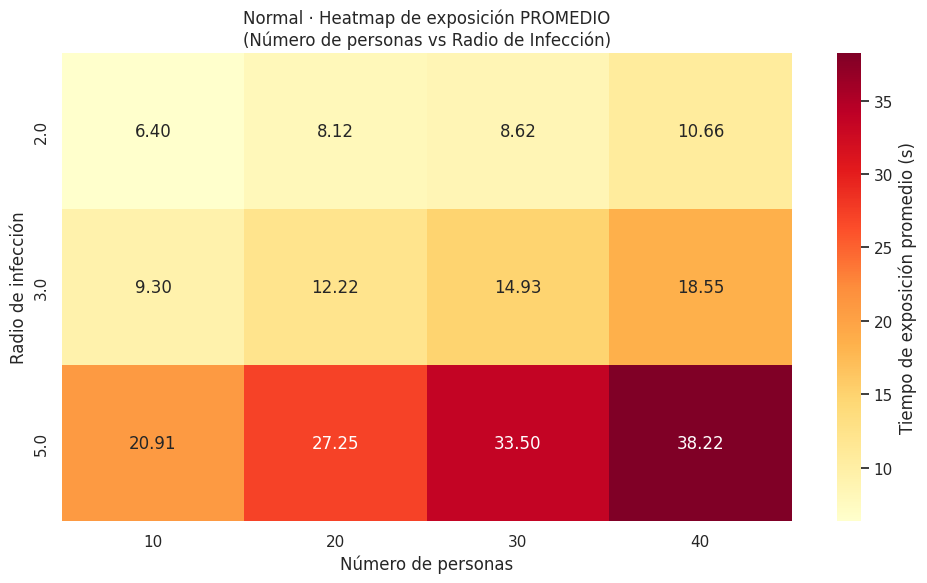

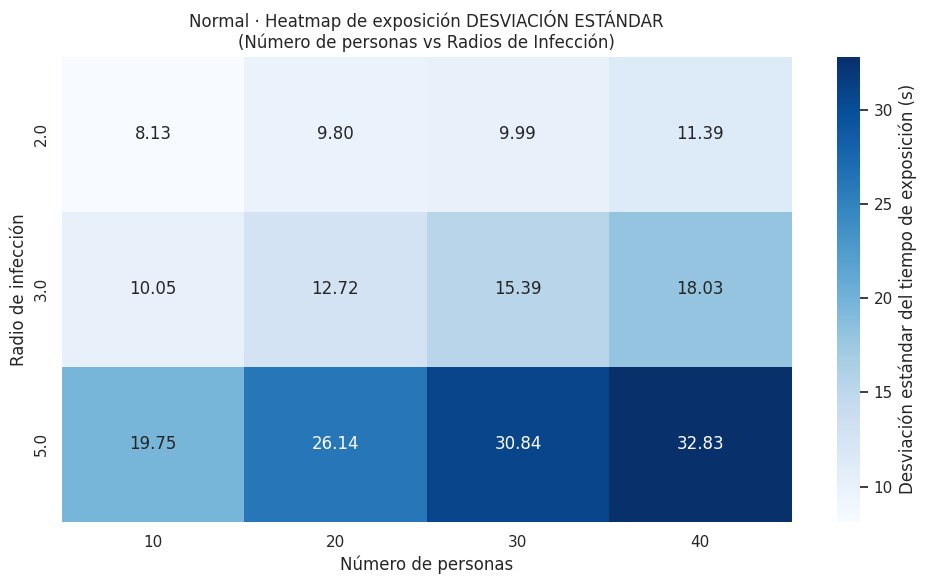

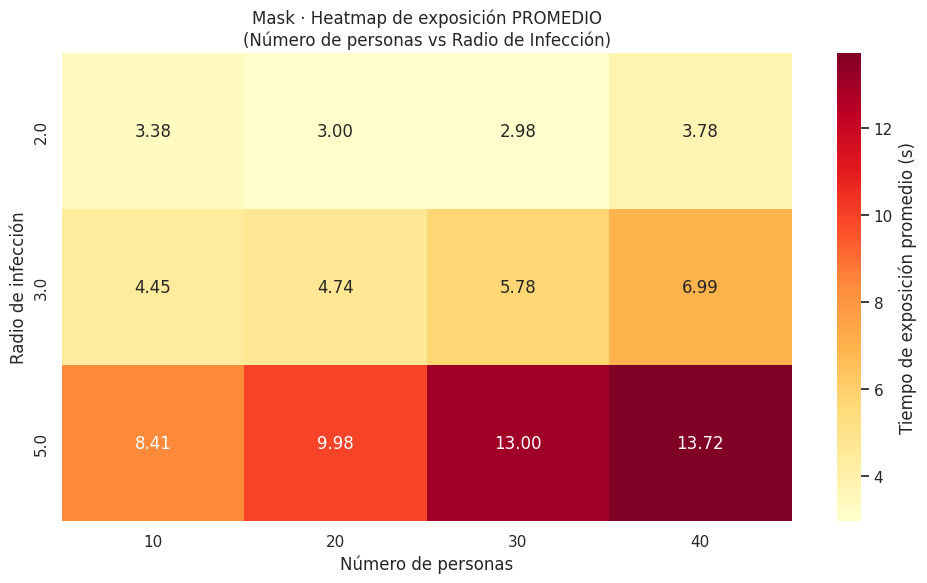

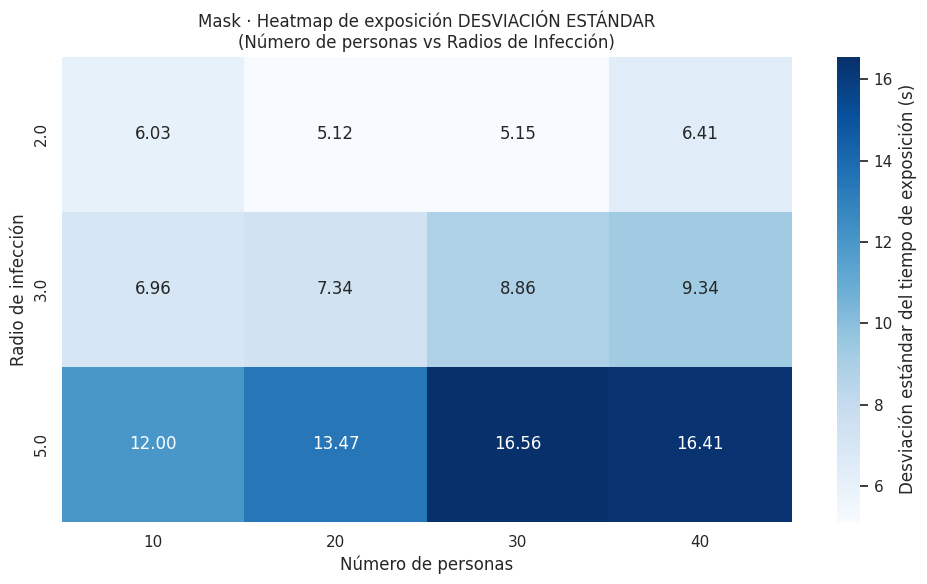

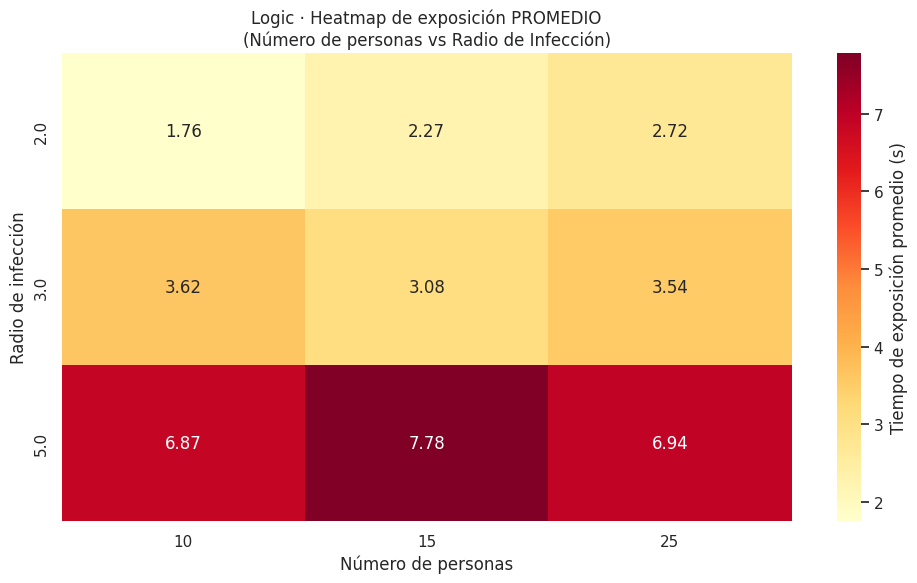

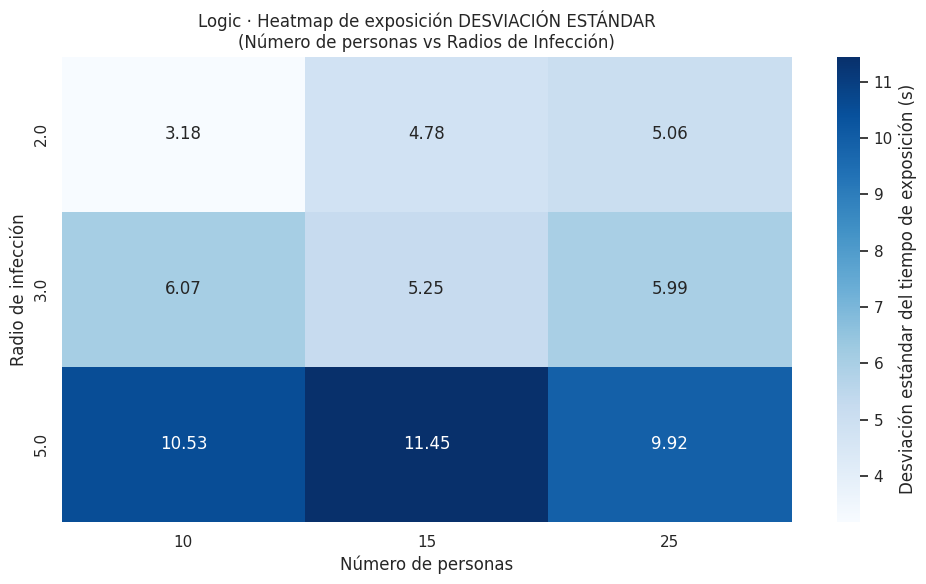

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

for label, pair in datasets.items():
    dfc = build_combined(pair["sims"], pair["pe"])

    # ---- Heatmap: Media ----
    heatmap_mean = (
        dfc.groupby(["infection_radius", "num_people"])["exposure_time_seconds"]
           .mean()
           .unstack()
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_mean,
        annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Tiempo de exposición promedio (s)'}
    )
    plt.title(f"{label} · Heatmap de exposición PROMEDIO\n(Número de personas vs Radio de Infección)")
    plt.xlabel("Número de personas")
    plt.ylabel("Radio de infección")
    plt.tight_layout()
    plt.show()

    # ---- Heatmap: Desviación estándar ----
    heatmap_std = (
        dfc.groupby(["infection_radius", "num_people"])["exposure_time_seconds"]
           .std()
           .unstack()
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_std,
        annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Desviación estándar del tiempo de exposición (s)'}
    )
    plt.title(f"{label} · Heatmap de exposición DESVIACIÓN ESTÁNDAR\n(Número de personas vs Radios de Infección)")
    plt.xlabel("Número de personas")
    plt.ylabel("Radio de infección")
    plt.tight_layout()
    plt.show()


En estos resultados se puede observar como la desviación estándar y el tiempo promedio de infección crece de manera menos constante cuando se implementan más intervenciones no farmaceúticas. Esto quiere decir que los tiempos de infección dependen más de la aleatoriedad de los modelos que de las variables epimediologicas que existen.

### Cambio promedio del tiempo de infección según la cantidad de personas y el radio de infección en todos los tipos de simulación.

Aquí se podrá observar de manera más directa lo explicado anteriormente, y es como los tiempos de infección son cada vez menos dependientes de la cantidad de personas y los radios de infección. Esto nos sugiere que esa clase de escenarios ya depende más de la aleatoriedad de las personas que de las variables que intervienen en la simulación.

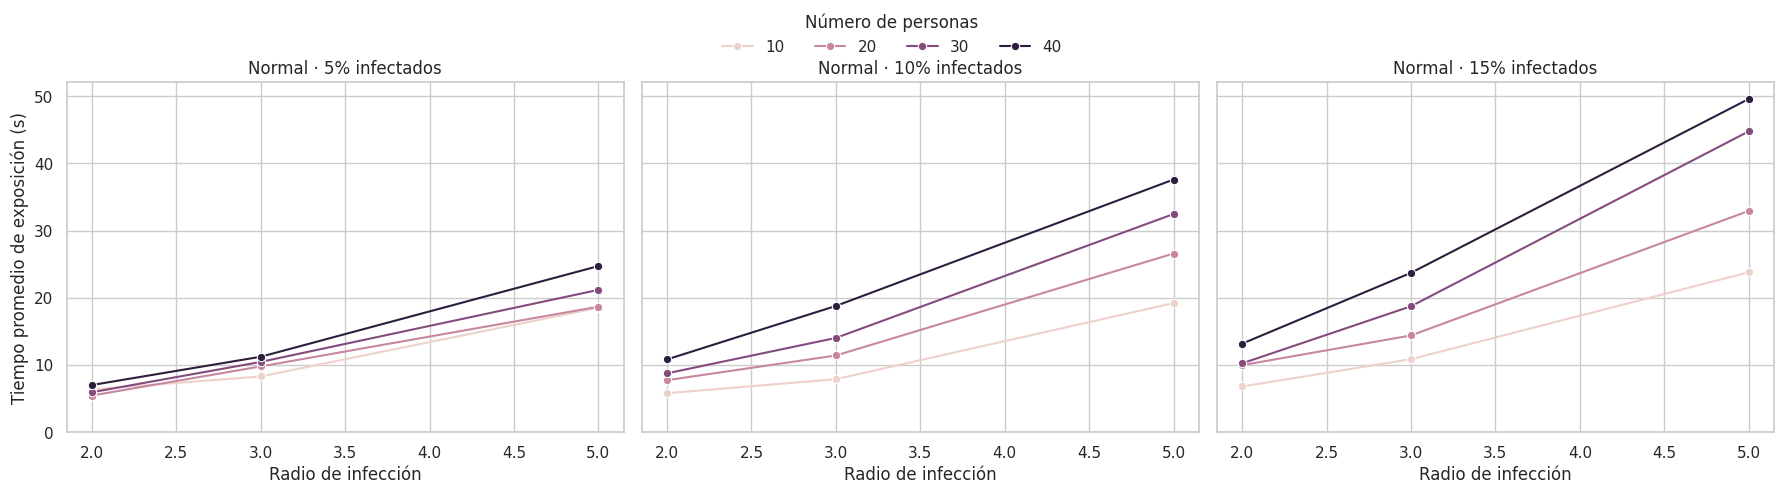

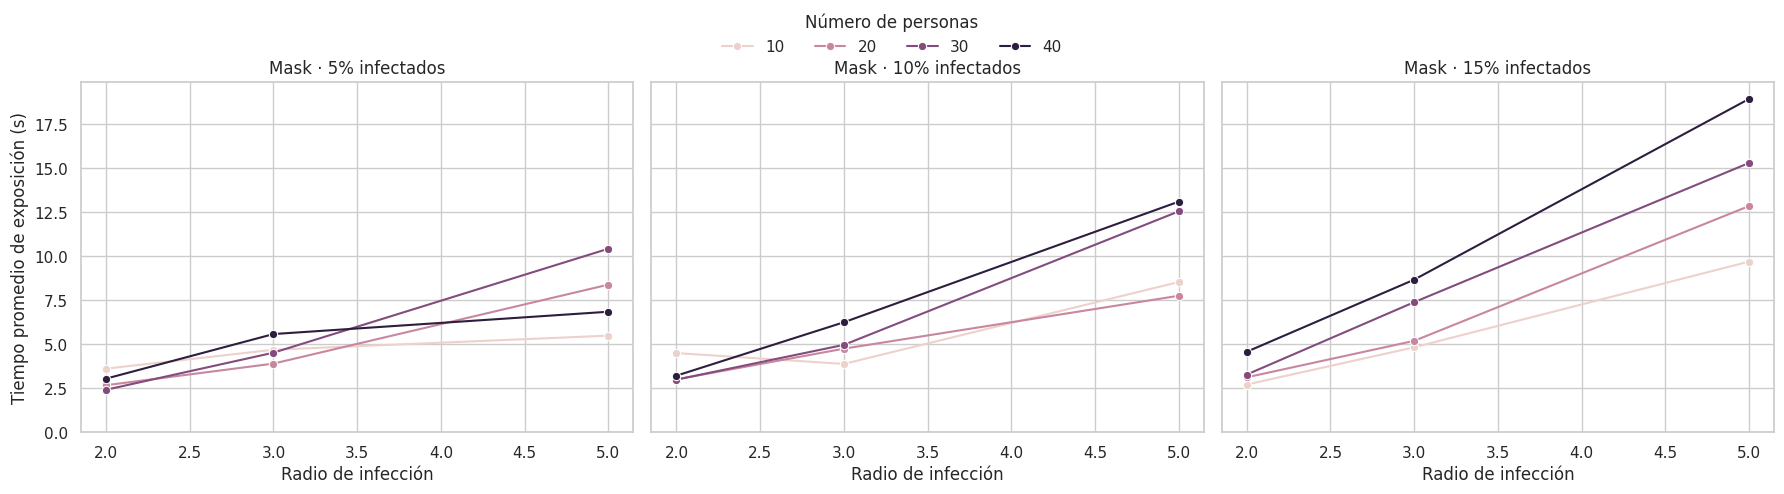

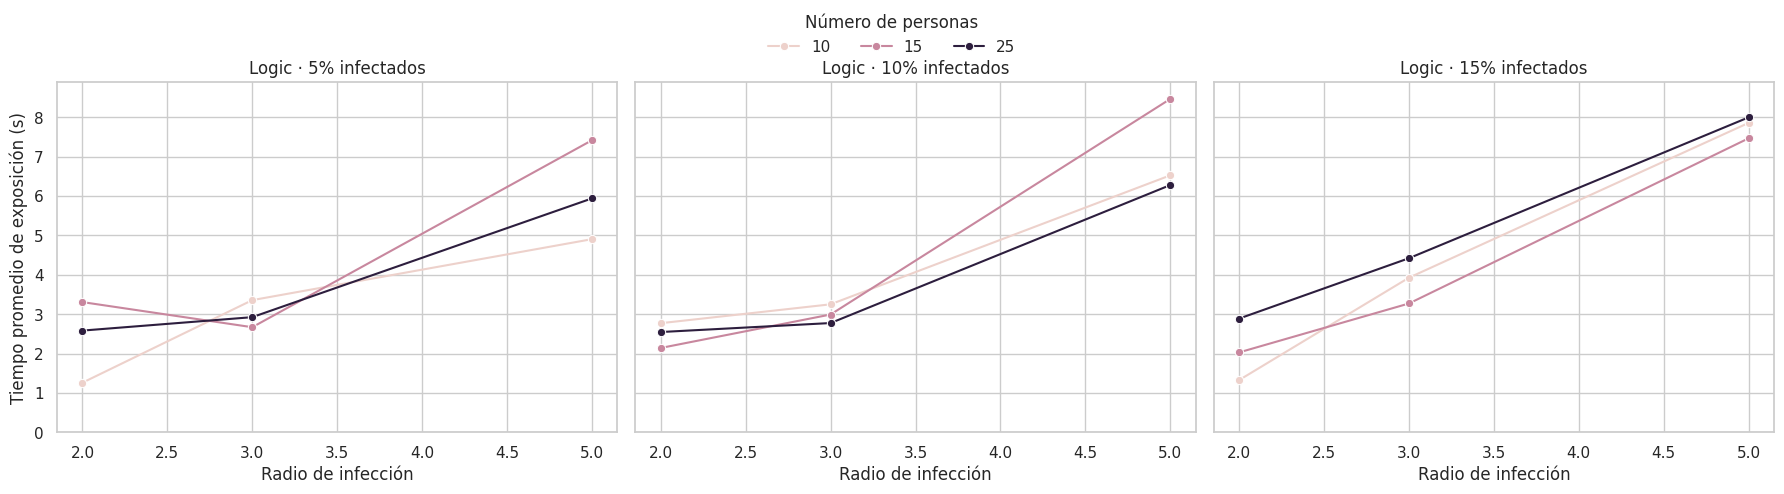

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Se reutilizan los dataframes

for label, pair in datasets.items():
    dfc = build_combined(pair["sims"], pair["pe"]).copy()

    # Asegurar tipos numéricos y limpiar
    for col in ["infection_radius", "num_people", "infected_percentage", "exposure_time_seconds"]:
        dfc[col] = pd.to_numeric(dfc[col], errors="coerce")
    dfc = dfc.dropna(subset=["infection_radius", "num_people", "infected_percentage", "exposure_time_seconds"])

    # Valores únicos (hasta 3) de infected_percentage
    pcts = sorted(dfc["infected_percentage"].dropna().unique())
    if not len(pcts):
        continue

    # Limites de Y consistentes entre subplots (media máxima entre todos los grupos)
    y_max = (
        dfc.groupby(["infected_percentage", "infection_radius", "num_people"])["exposure_time_seconds"]
           .mean()
           .max()
    )
    y_pad = 0.05 * y_max if np.isfinite(y_max) and y_max > 0 else 1.0

    # Crear figura 1×N (N=3 normalmente)
    fig, axes = plt.subplots(1, len(pcts), figsize=(6*len(pcts), 5), sharey=True)

    # Si solo hay 1 porcentaje, axes no es iterable
    if len(pcts) == 1:
        axes = [axes]

    # Para una leyenda única al final
    handles_labels = None

    for i, pct in enumerate(pcts):
        ax = axes[i]
        sub = dfc[dfc["infected_percentage"] == pct]

        # Agregar: promedio por combinación (infection_radius, num_people)
        mean_exposure = (
            sub.groupby(["infection_radius", "num_people"])["exposure_time_seconds"]
               .mean()
               .reset_index()
               .sort_values(["infection_radius", "num_people"])
        )

        # Asegurar orden del eje X por el valor de infection_radius
        mean_exposure = mean_exposure.sort_values("infection_radius")

        # Lineplot: una línea por num_people
        ln = sns.lineplot(
            data=mean_exposure,
            x="infection_radius", y="exposure_time_seconds",
            hue="num_people", marker="o", ax=ax
        )

        ax.set_title(f"{label} · {int(pct)}% infectados")
        ax.set_xlabel("Radio de infección")
        ax.set_ylabel("Tiempo promedio de exposición (s)" if i == 0 else "")
        ax.set_ylim(0, y_max + y_pad)

        # Guardar handles/labels para leyenda global
        if handles_labels is None:
            handles_labels = ax.get_legend_handles_labels()
        # Quitar leyenda local de cada subplot
        ax.get_legend().remove()

    # Leyenda global (número de personas)
    if handles_labels is not None:
        handles, labels_ = handles_labels
        fig.legend(handles, labels_, title="Número de personas", loc="upper center", ncol=min(4, len(labels_)), frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.92])  # deja espacio para la leyenda arriba
    plt.show()



### Gráficos de distribución de diferentes intervalos de tiempo

El siguiente gráfico nos muestra como se distribuyen los tiempos de infección de los diferentes tipos de simulaciones considerando diferentes intervalos de tiempo de infección. 

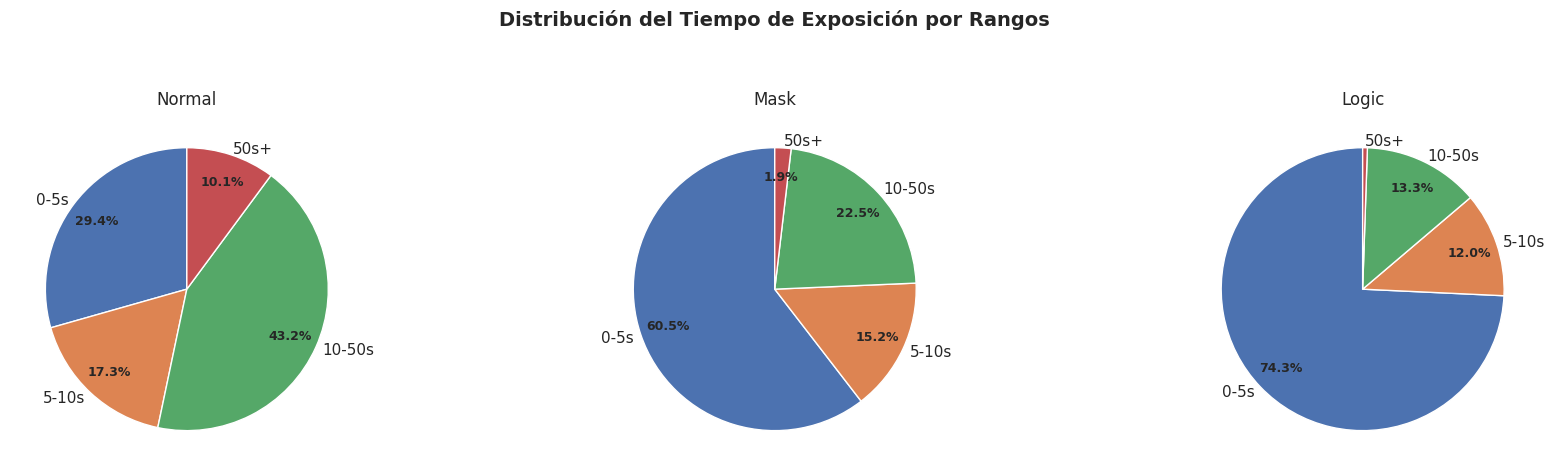

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Rango de tiempos reducido a 4 categorías
bins = [0, 5, 10, 50, np.inf]
labels = ["0-5s", "5-10s", "10-50s", "50s+"]

def prep_df(dfc):
    dfc["exposure_time_seconds"] = pd.to_numeric(dfc["exposure_time_seconds"], errors="coerce")
    dfc = dfc.dropna(subset=["exposure_time_seconds"])
    dfc["time_bucket"] = pd.cut(dfc["exposure_time_seconds"], bins=bins, labels=labels, right=False)
    return dfc

def pie_autopct(pct):
    return f"{pct:.1f}%" if pct >= 1 else ""

fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 5))

if len(datasets) == 1:
    axes = [axes]

for ax, (label, pair) in zip(axes, datasets.items()):
    dfc = prep_df(build_combined(pair["sims"], pair["pe"]).copy())

    counts = dfc["time_bucket"].value_counts().reindex(labels, fill_value=0)

    if counts.sum() == 0:
        ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
        ax.axis("off")
        continue

    wedges, texts, autotexts = ax.pie(
        counts.values,
        labels=counts.index,
        startangle=90,
        autopct=pie_autopct,
        pctdistance=0.8,
        labeldistance=1.05
    )
    ax.set_title(f"{label}")

    for t in autotexts:
        t.set_fontsize(9)
        t.set_weight("bold")

fig.suptitle("Distribución del Tiempo de Exposición por Rangos", fontsize=14, fontweight="bold", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


Se puede observar como cada vez que se implementan las intervenciones no farmaceúticas los tiempos de infección bajan cada vez más, cada vez crece más el porcentaje de intervalo de tiempo de infección más pequeño mientras al mismo tiempo se reducen los intervalos de infección con tiempos de infección más grandes.

### Distribución del tiempo de infección según todas las variables utilizadas. 

El siguente gráfico nos ayuda a visualizar las distribuciones de los tiempo de infección según los diferentes todas las variables utilizadas en los tipos de simulación.



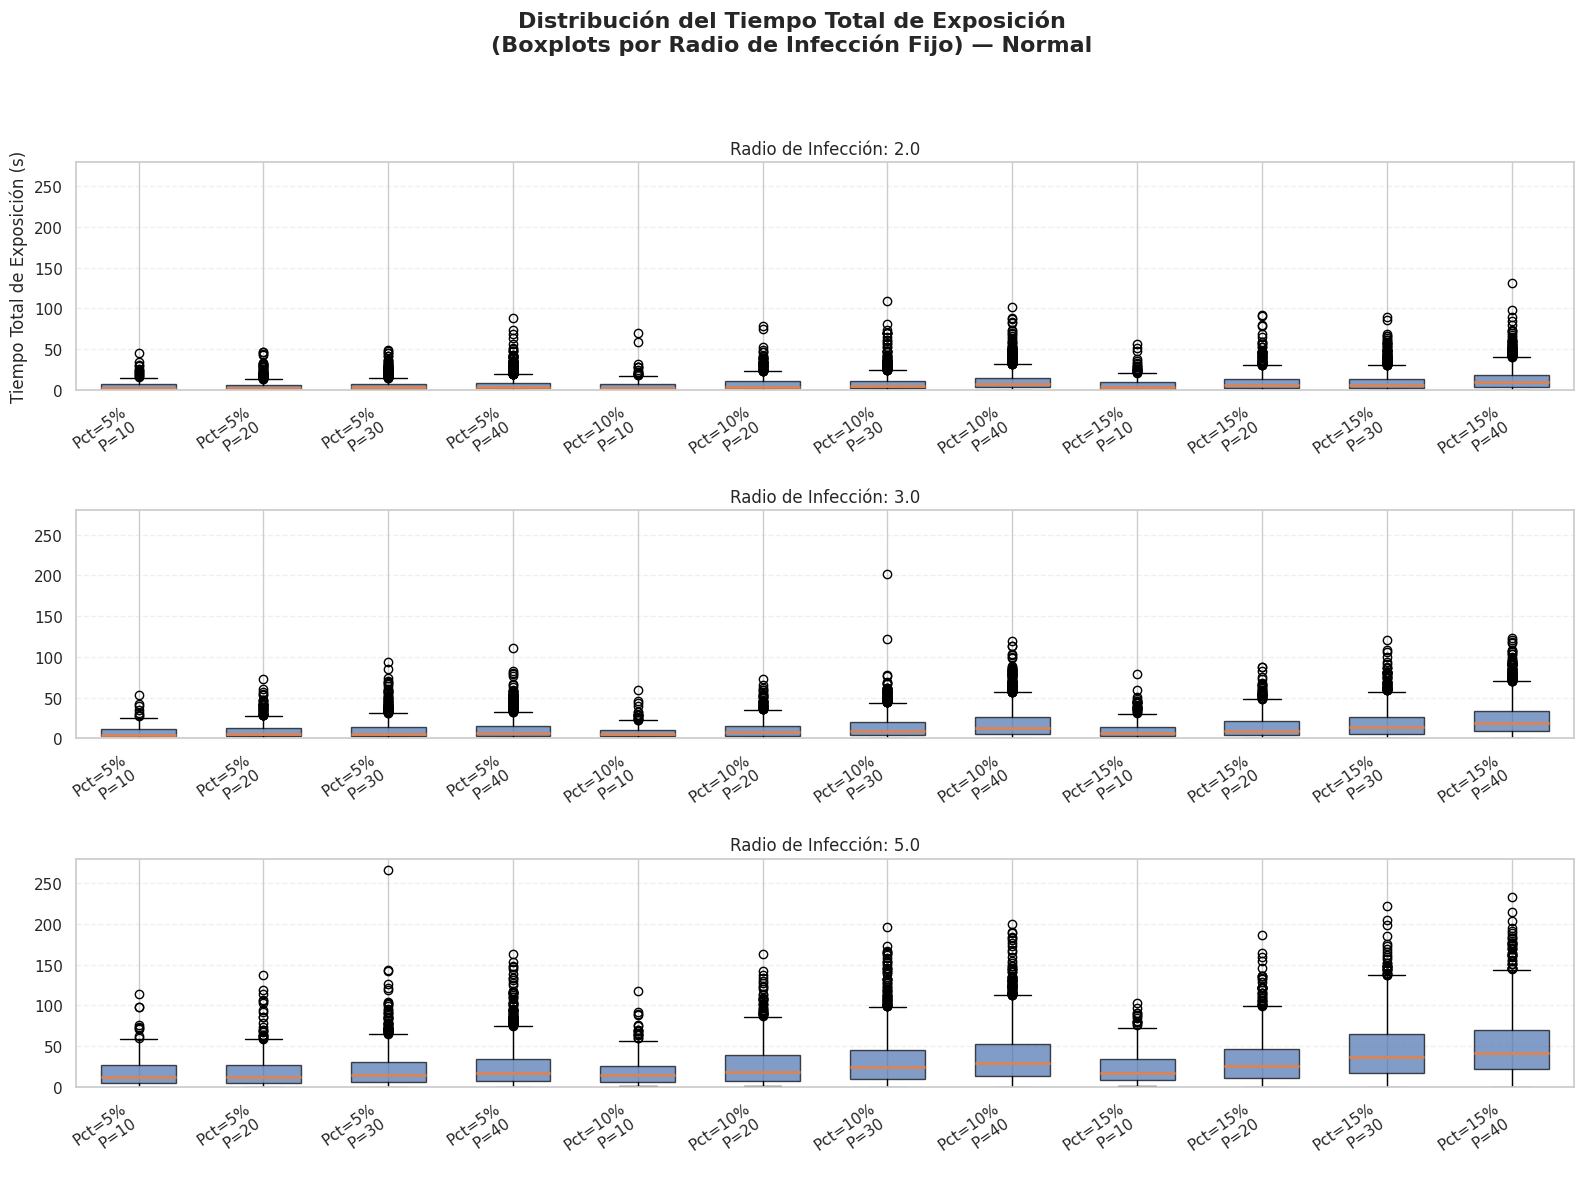

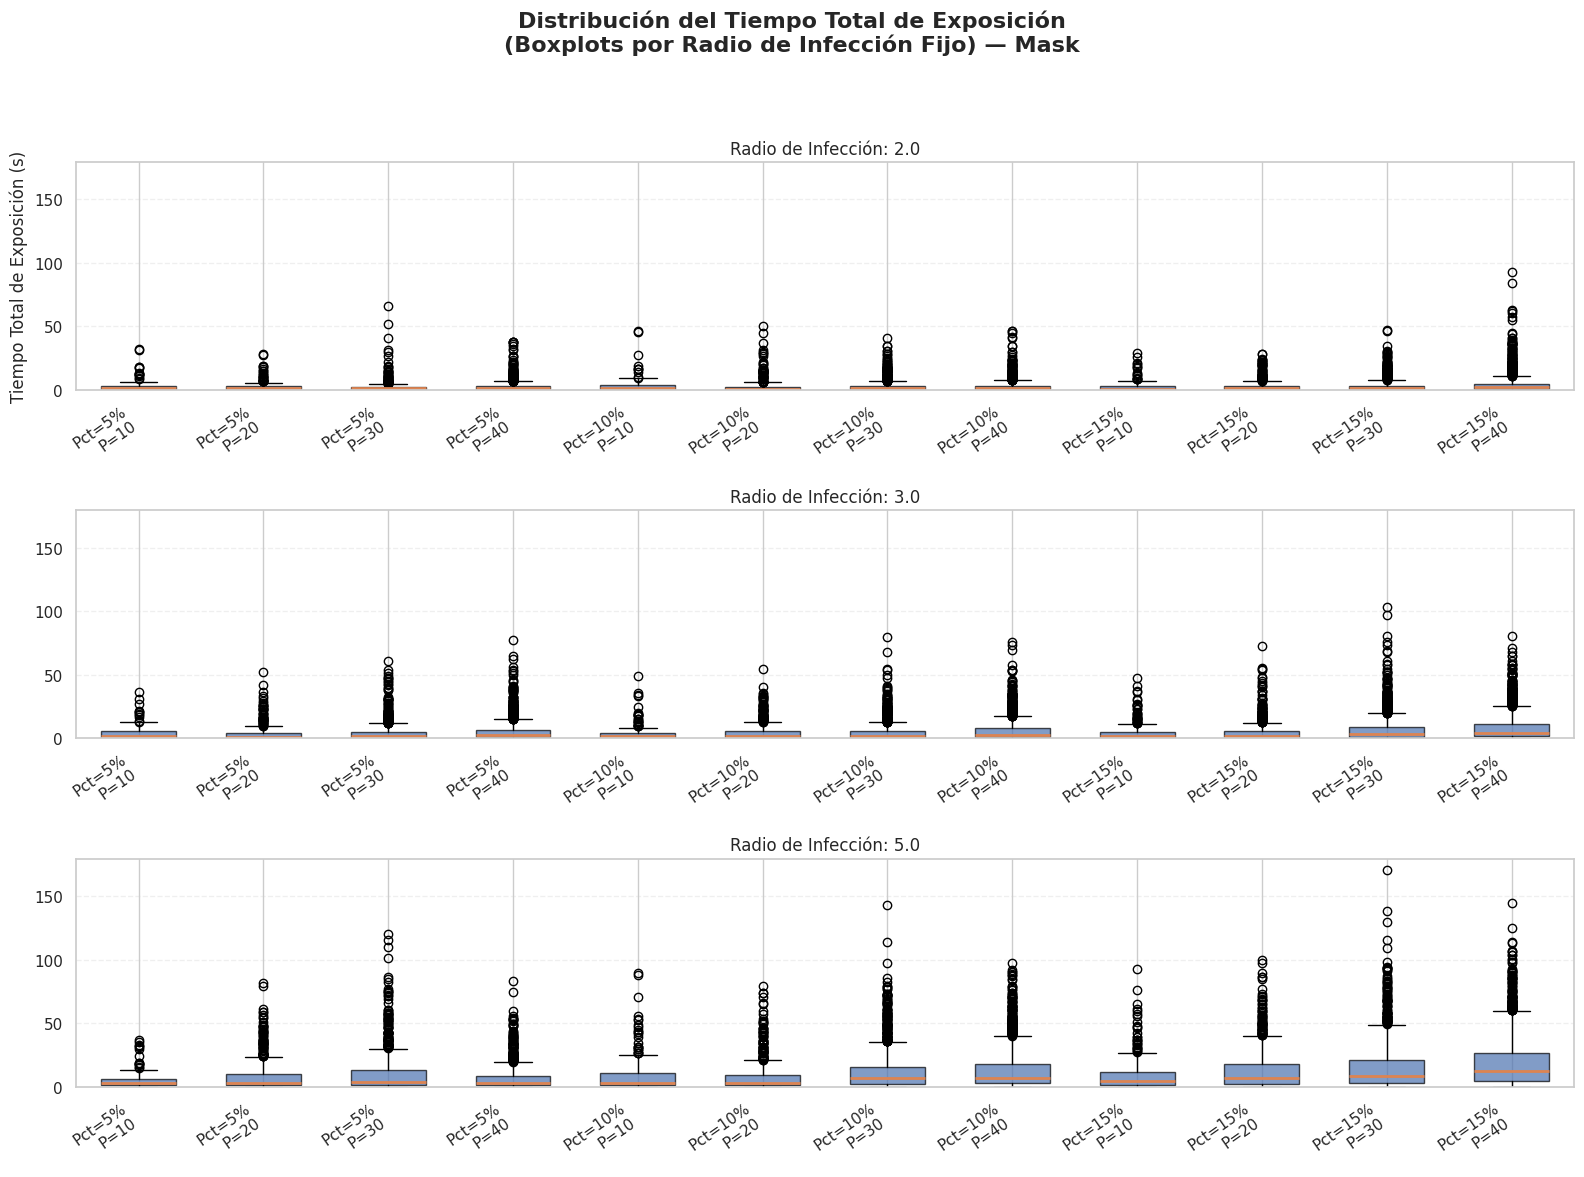

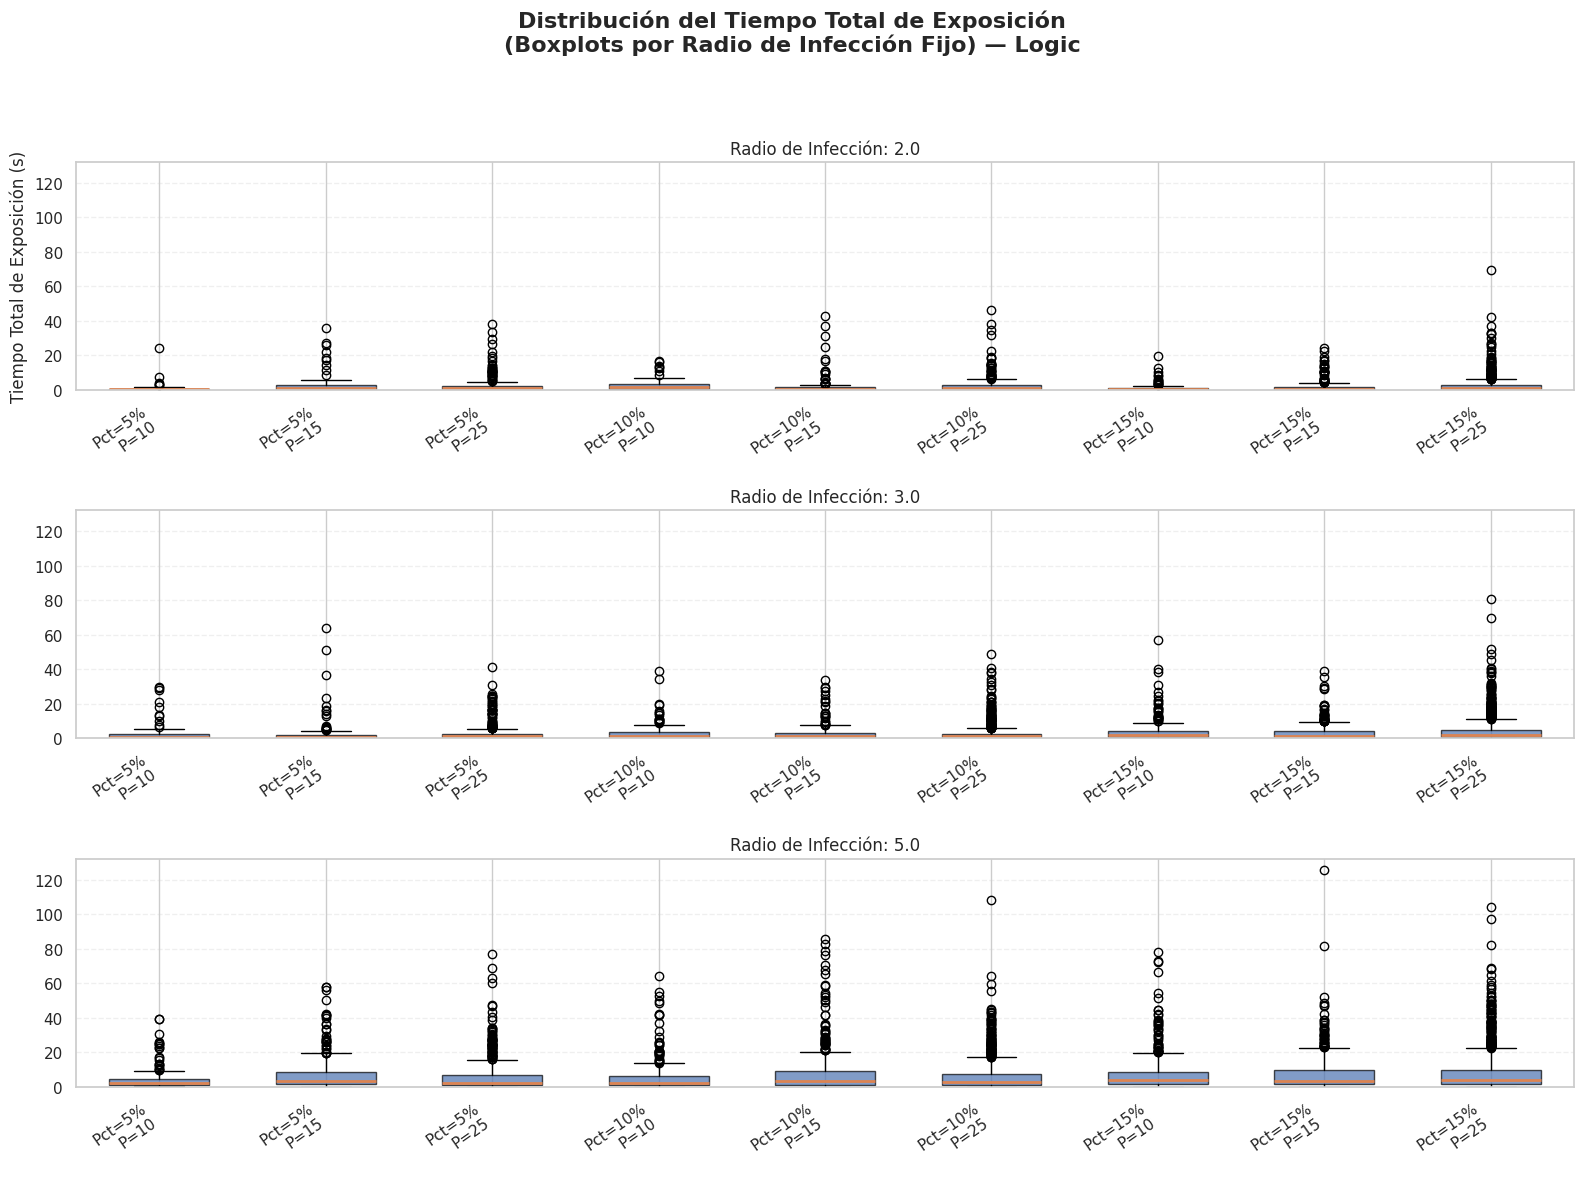

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reutiliza tus pares y la función build_combined(...) ya definida antes
# datasets = { "General": {"sims": df_sims, "pe": df_pe}, ... }

def to_numeric_cols(dfc):
    for col in ["exposure_time_seconds", "infection_radius", "num_people", "infected_percentage"]:
        dfc[col] = pd.to_numeric(dfc[col], errors="coerce")
    return dfc.dropna(subset=["exposure_time_seconds", "infection_radius", "num_people", "infected_percentage"])

for label, pair in datasets.items():
    dfc = to_numeric_cols(build_combined(pair["sims"], pair["pe"]).copy())

    radii = sorted(dfc["infection_radius"].dropna().unique())
    pcts  = sorted(dfc["infected_percentage"].dropna().unique())
    ppl   = sorted(dfc["num_people"].dropna().unique())

    if not len(radii):
        continue

    # Consistencia del eje Y en todos los subplots de este panel
    y_max = dfc["exposure_time_seconds"].max()
    y_pad = 0.05*y_max if np.isfinite(y_max) and y_max>0 else 1.0

    fig, axes = plt.subplots(len(radii), 1, figsize=(16, 4*len(radii)), sharey=True)
    if len(radii) == 1:
        axes = [axes]

    # Título general
    fig.suptitle(
        "Distribución del Tiempo Total de Exposición\n(Boxplots por Radio de Infección Fijo) — " + label,
        fontsize=16, fontweight="bold", y=0.98
    )

    for i, r in enumerate(radii):
        ax = axes[i]
        sub_r = dfc[dfc["infection_radius"] == r]

        data_per_cat = []
        labels_per_cat = []

        # Recorremos en orden (pct, people) para etiquetas consistentes
        for pct in pcts:
            for p in ppl:
                vals = sub_r[(sub_r["infected_percentage"] == pct) &
                             (sub_r["num_people"] == p)]["exposure_time_seconds"].dropna().values
                if len(vals) > 0:
                    data_per_cat.append(vals)
                    labels_per_cat.append(f"Pct={int(pct)}%\nP={int(p)}")
                # Si una combinación no existe, la omitimos (evita errores de posiciones)

        if len(data_per_cat) == 0:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_axis_off()
            continue

        # Boxplot con Matplotlib (robusto ante categorías desbalanceadas)
        bp = ax.boxplot(data_per_cat, vert=True, patch_artist=True, widths=0.6)

        # (Opcional) estilizar un poco las cajas
        for box in bp['boxes']:
            box.set(alpha=0.7)
        for median in bp['medians']:
            median.set(linewidth=2)

        ax.set_title(f"Radio de Infección: {r}", fontsize=12)
        ax.set_xticks(range(1, len(labels_per_cat) + 1))
        ax.set_xticklabels(labels_per_cat, rotation=35, ha="right")
        ax.set_ylabel("Tiempo Total de Exposición (s)" if i == 0 else "")
        ax.set_ylim(0, y_max + y_pad)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


Estos gráficos nos ayuda a confirmar nuevamente como el radio de infección es la variable que tiene más peso a la hora de incrementar los tiempos de infección en las simulaciones. Cabe destacar que este radio de infección representa que tan pobre es la falta de ventilación en un ambiente.

### Distribución de los tiempos de infección en las áreas del ambiente según los diferentes tipos de simulaciones

Este último gráfico nos ayuda a visualizar cuales son las áreas más críticas de infección que tenemos en la simulación.

Normal · Top 5 puntos con mayor exposición
X: 1500, Y (Pygame): 250 (Original: 360) — 32.40s
X: 1510, Y (Pygame): 370 (Original: 240) — 31.60s
X: 1510, Y (Pygame): 260 (Original: 350) — 26.20s
X: 1490, Y (Pygame): 250 (Original: 360) — 22.80s
X: 1510, Y (Pygame): 370 (Original: 240) — 22.40s

Mask · Top 5 puntos con mayor exposición
X: 1510, Y (Pygame): 470 (Original: 140) — 26.00s
X: 1510, Y (Pygame): 460 (Original: 150) — 25.00s
X: 1510, Y (Pygame): 360 (Original: 250) — 18.20s
X: 1510, Y (Pygame): 370 (Original: 240) — 16.00s
X: 1500, Y (Pygame): 380 (Original: 230) — 10.60s

Logic · Top 5 puntos con mayor exposición
X: 1500, Y (Pygame): 250 (Original: 360) — 17.60s
X: 1510, Y (Pygame): 260 (Original: 350) — 9.80s
X: 1380, Y (Pygame): 210 (Original: 400) — 9.20s
X: 1510, Y (Pygame): 370 (Original: 240) — 8.60s
X: 1510, Y (Pygame): 170 (Original: 440) — 8.20s



/tmp/ipykernel_6869/1417656118.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 0.95])


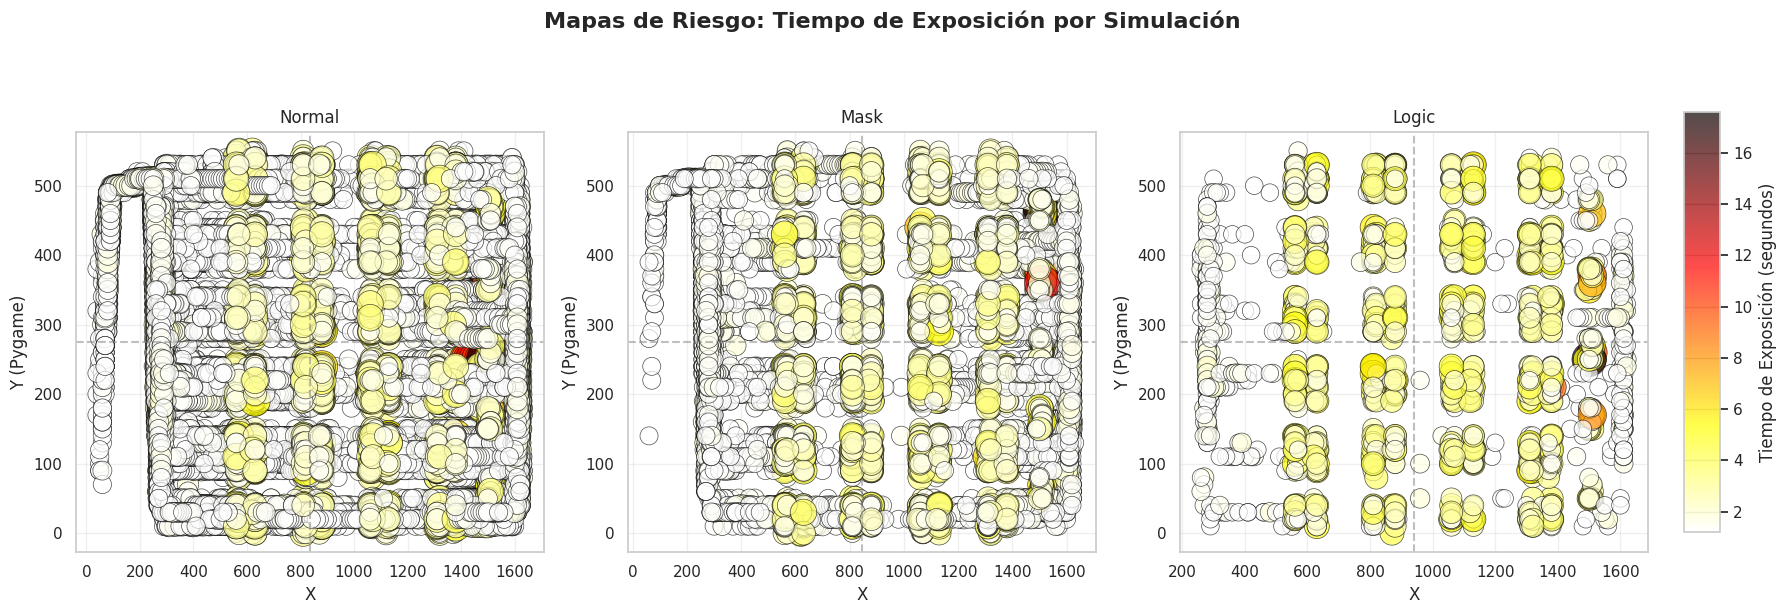

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Funciones auxiliares ---
def prep_df_le(df, arena_height_strategy="max"):
    df = df.copy()
    for col in ["x_coordinate", "y_coordinate", "exposure_time_seconds"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["x_coordinate", "y_coordinate", "exposure_time_seconds"])

    if isinstance(arena_height_strategy, (int, float)):
        H = float(arena_height_strategy)
    else:
        H = float(df["y_coordinate"].max()) if len(df) else 0.0
    df["y_coordinate_pygame"] = H - df["y_coordinate"]
    return df, H

def auto_size_scale(values):
    if len(values) == 0:
        return 20.0
    p95 = np.percentile(values, 95)
    if p95 <= 0:
        return 20.0
    return 300.0 / np.sqrt(p95)

# --- Dataframes por tipo de simulación ---
datasets_le = {
    "Normal":  df_le_normal,
    "Mask":    df_le_mask,
    "Logic":   df_le_logic,
}

# --- Figura con subplots 1x4 ---
fig, axes = plt.subplots(1, len(datasets_le), figsize=(6*len(datasets_le), 6), sharex=False, sharey=False)

if len(datasets_le) == 1:
    axes = [axes]

for ax, (label, df_le_cur) in zip(axes, datasets_le.items()):
    df, H = prep_df_le(df_le_cur)
    if df.empty:
        ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
        ax.axis("off")
        continue

    size_scale = auto_size_scale(df["exposure_time_seconds"])
    sizes = np.sqrt(df["exposure_time_seconds"]) * size_scale

    scatter = ax.scatter(
        df["x_coordinate"], df["y_coordinate_pygame"],
        s=sizes,
        c=df["exposure_time_seconds"],
        cmap="hot_r",
        alpha=0.7,
        edgecolors="black", linewidth=0.5
    )
    ax.set_title(label)
    ax.set_xlabel("X")
    ax.set_ylabel("Y (Pygame)")
    ax.grid(True, alpha=0.3)

    # Líneas de cuadrantes
    x_min, x_max = df["x_coordinate"].min(), df["x_coordinate"].max()
    y_min, y_max = df["y_coordinate_pygame"].min(), df["y_coordinate_pygame"].max()
    ax.axvline(x=(x_min + x_max)/2, color="gray", linestyle="--", alpha=0.5)
    ax.axhline(y=(y_min + y_max)/2, color="gray", linestyle="--", alpha=0.5)

    # --- Top 5 puntos con mayor exposición ---
    print("="*70)
    print(f"{label} · Top 5 puntos con mayor exposición")
    print("="*70)
    top_points = df.nlargest(5, "exposure_time_seconds")[
        ["x_coordinate", "y_coordinate", "y_coordinate_pygame", "exposure_time_seconds"]
    ]
    for _, row in top_points.iterrows():
        print(
            f"X: {row['x_coordinate']:.0f}, "
            f"Y (Pygame): {row['y_coordinate_pygame']:.0f} "
            f"(Original: {row['y_coordinate']:.0f}) — {row['exposure_time_seconds']:.2f}s"
        )
    print()

# --- Colorbar común ---
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label="Tiempo de Exposición (segundos)")

plt.suptitle("Mapas de Riesgo: Tiempo de Exposición por Simulación", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0, 0, 0.93, 0.95])
plt.show()


Se puede observar como cada vez que se implementa las intervenciones no farmeceuticas los puntos de tiempos de infeección se reducen de manera significativa, también se observa como reducir la cantidad de personas y eliminar las filas ayuda que no se generen puntos de infección en esos lugares. Algo que cabe destacar que con este tipo de herramientas visuales los encargados pueden verificar cuales son las zonas más críticas de infección que tienen sus locales y de esta manera ver como actuar en ellos.